The goal of this project is :
 - Identify main reason for customer satisfaction or dissatisfaction
 - Predict satisfaction level by category and product type


In [1]:
import pandas as pd
import numpy as np
import nltk
nltk.download('wordnet')
nltk.download('stopwords')
nltk.download('rslp')
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC, LinearSVC
from sklearn.ensemble import RandomForestClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.linear_model import Perceptron
from sklearn.linear_model import SGDClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn import datasets
from sklearn.multiclass import OneVsRestClassifier
from sklearn.svm import LinearSVC
import matplotlib.pyplot as plt
#import string
%matplotlib inline


import numpy
import matplotlib.pyplot as plt
import string
import re
from gensim import corpora
from gensim.models import Phrases
from nltk.corpus import stopwords
from nltk.stem.porter import PorterStemmer

[nltk_data] Downloading package wordnet to
[nltk_data]     /Users/anurkayeva/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package stopwords to
[nltk_data]     /Users/anurkayeva/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package rslp to /Users/anurkayeva/nltk_data...
[nltk_data]   Package rslp is already up-to-date!
/anaconda3/lib/python3.7/site-packages/sklearn/ensemble/weight_boosting.py:29: DeprecationWarning: numpy.core.umath_tests is an internal NumPy module and should not be imported. It will be removed in a future NumPy release.
  from numpy.core.umath_tests import inner1d


# Preprocessing

In [3]:
reviews = pd.read_csv('brazilian-ecommerce/olist_order_reviews_dataset.csv', header=1 )
reviews
reviews.review_comment_title = reviews.review_comment_title.fillna('')
reviews.review_comment_message = reviews.review_comment_message.fillna('')
reviews["review_comment"] = reviews['review_comment_title'].map(str) + ' ' + reviews['review_comment_message'].map(str)
reviews['review_comment'] = reviews['review_comment'].apply(lambda x: ' '.join(pd.unique(x.split())))
#reviews_only = reviews[pd.notnull(reviews['review_comment'])]
reviews.head()
reviews = reviews[pd.notnull(reviews['review_comment_title']) | pd.notnull(reviews['review_comment_message'])]
reviews['review_comment']  = reviews['review_comment'] .str.replace('[^\w\s]','')
reviews['review_comment']  = reviews['review_comment'].str.lower()
reviews.head()



/anaconda3/lib/python3.7/site-packages/IPython/core/interactiveshell.py:2785: DtypeWarning: Columns (7,15,19) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


,review_id,order_id,review_score,review_comment_title,review_comment_message,review_creation_date,review_answer_timestamp,concat,DELIVERY,quality,...,cs,price,delivery,delivery_not del,quality .1,quantity.1,wrong_item,cs.1,Unnamed: 19,review_comment
0,7bc2406110b926393aa56f80a40eba40,73fc7af87114b39712e6da79b0a377eb,4,,,1/18/18 0:00,1/18/18 21:46,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,
1,80e641a11e56f04c1ad469d5645fdfde,a548910a1c6147796b98fdf73dbeba33,5,,,3/10/18 0:00,3/11/18 3:05,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,
2,228ce5500dc1d8e020d8d1322874b6f0,f9e4b658b201a9f2ecdecbb34bed034b,5,,,2/17/18 0:00,2/18/18 14:36,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,
3,e64fb393e7b32834bb789ff8bb30750e,658677c97b385a9be170737859d3511b,5,,Recebi bem antes do prazo estipulado.,4/21/17 0:00,4/21/17 22:02,Recebi bem antes do prazo estipulado.,1.0,0.0,...,0.0,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,recebi bem antes do prazo estipulado
4,f7c4243c7fe1938f181bec41a392bdeb,8e6bfb81e283fa7e4f11123a3fb894f1,5,,Parabéns lojas lannister adorei comprar pela I...,3/1/18 0:00,3/2/18 10:26,Parabéns lojas lannister adorei comprar pela I...,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,parabéns lojas lannister adorei comprar pela i...


In [4]:
from nltk.stem.porter import PorterStemmer
stemmer = nltk.stem.RSLPStemmer()
stopwords = nltk.corpus.stopwords.words('portuguese')
#stopwords = set(stopwords) - set(('não'))
#noise_words = ['recebemo', 'recebimento', 'nan','produto','correio', 'entregu','recomendo','compra', 'comprar','recebi', 'compra', 'entregu', 'entrega', 'entregoa', 'comprei',  'veio', 'é', 'pedido' , 'chegou', 'apena']
#recebemo" + 0.009*"funciona" + 0.009*"recebimento"
#" + 0.025*"veio" + 0.024*"é" + 0.017*"entregu" + 0.013*"pedido" + 0.013*"chegou" + 0.011*"apena" + 0.011*"qualidad" + 0.010*"recomendo"



reviews['review_comment_t']  = reviews['review_comment'] .str.replace('[^\w\s]','')
reviews['review_comment_t']  = reviews['review_comment_t'] .str.lower().str.split()
#reviews['review_comment_t'] =  reviews['review_comment_t'].apply(lambda x: [item for item in x if item not in stopwords ])

#reviews['review_comment_t'] =  reviews['review_comment_t'].apply(lambda x: [item for item in x if item not in noise_words ])

reviews['review_comment_t_stem'] = reviews['review_comment_t'].apply(lambda x: [stemmer.stem(y) for y in x])
reviews[reviews['review_score']<3][['review_comment','review_comment_t']].head()
reviews

,review_id,order_id,review_score,review_comment_title,review_comment_message,review_creation_date,review_answer_timestamp,concat,DELIVERY,quality,...,delivery,delivery_not del,quality .1,quantity.1,wrong_item,cs.1,Unnamed: 19,review_comment,review_comment_t,review_comment_t_stem
0,7bc2406110b926393aa56f80a40eba40,73fc7af87114b39712e6da79b0a377eb,4,,,1/18/18 0:00,1/18/18 21:46,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,,[],[]
1,80e641a11e56f04c1ad469d5645fdfde,a548910a1c6147796b98fdf73dbeba33,5,,,3/10/18 0:00,3/11/18 3:05,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,,[],[]
2,228ce5500dc1d8e020d8d1322874b6f0,f9e4b658b201a9f2ecdecbb34bed034b,5,,,2/17/18 0:00,2/18/18 14:36,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,,[],[]
3,e64fb393e7b32834bb789ff8bb30750e,658677c97b385a9be170737859d3511b,5,,Recebi bem antes do prazo estipulado.,4/21/17 0:00,4/21/17 22:02,Recebi bem antes do prazo estipulado.,1.0,0.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,recebi bem antes do prazo estipulado,"[recebi, bem, antes, do, prazo, estipulado]","[receb, bem, ant, do, praz, estipul]"
4,f7c4243c7fe1938f181bec41a392bdeb,8e6bfb81e283fa7e4f11123a3fb894f1,5,,Parabéns lojas lannister adorei comprar pela I...,3/1/18 0:00,3/2/18 10:26,Parabéns lojas lannister adorei comprar pela I...,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,parabéns lojas lannister adorei comprar pela i...,"[parabéns, lojas, lannister, adorei, comprar, ...","[parabém, loj, lannist, ador, compr, pel, inte..."
5,15197aa66ff4d0650b5434f1b46cda19,b18dcdf73be66366873cd26c5724d1dc,1,,,4/13/18 0:00,4/16/18 0:39,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,,[],[]
6,07f9bee5d1b850860defd761afa7ff16,e48aa0d2dcec3a2e87348811bcfdf22b,5,,,7/16/17 0:00,7/18/17 19:30,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,,[],[]
7,7c6400515c67679fbee952a7525281ef,c31a859e34e3adac22f376954e19b39d,5,,,8/14/18 0:00,8/14/18 21:36,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,,[],[]
8,a3f6f7f6f433de0aefbb97da197c554c,9c214ac970e84273583ab523dfafd09b,5,,,5/17/17 0:00,5/18/17 12:05,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,,[],[]
9,8670d52e15e00043ae7de4c01cc2fe06,b9bf720beb4ab3728760088589c62129,4,recomendo,aparelho eficiente. no site a marca do aparelh...,5/22/18 0:00,5/23/18 16:45,recomendoaparelho eficiente. no site a marca d...,0.0,0.0,...,0.0,0.0,0,0.0,1.0,0.0,NaN,recomendo aparelho eficiente no site a marca d...,"[recomendo, aparelho, eficiente, no, site, a, ...","[recom, aparelh, efici, no, sit, a, marc, do, ..."


# Exploratory sentiment analysis

In [5]:
reviews['review_pos_neg'] = reviews['review_score'] 
reviews.head()

#reviews_only['review_pos_neg'] ([0, 1, 2, 3, 4, 5], ['neg', 'neg', 'neg', 'neg', 'pos', 'pos'])
reviews['review_pos_neg'] = reviews['review_pos_neg'].map({1: 'neg', 2: 'neg', 3: 'neg', 4: 'neg', 5:'pos' })
reviews.head()

,review_id,order_id,review_score,review_comment_title,review_comment_message,review_creation_date,review_answer_timestamp,concat,DELIVERY,quality,...,delivery_not del,quality .1,quantity.1,wrong_item,cs.1,Unnamed: 19,review_comment,review_comment_t,review_comment_t_stem,review_pos_neg
0,7bc2406110b926393aa56f80a40eba40,73fc7af87114b39712e6da79b0a377eb,4,,,1/18/18 0:00,1/18/18 21:46,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,,[],[],neg
1,80e641a11e56f04c1ad469d5645fdfde,a548910a1c6147796b98fdf73dbeba33,5,,,3/10/18 0:00,3/11/18 3:05,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,,[],[],pos
2,228ce5500dc1d8e020d8d1322874b6f0,f9e4b658b201a9f2ecdecbb34bed034b,5,,,2/17/18 0:00,2/18/18 14:36,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,,[],[],pos
3,e64fb393e7b32834bb789ff8bb30750e,658677c97b385a9be170737859d3511b,5,,Recebi bem antes do prazo estipulado.,4/21/17 0:00,4/21/17 22:02,Recebi bem antes do prazo estipulado.,1.0,0.0,...,NaN,NaN,NaN,NaN,NaN,NaN,recebi bem antes do prazo estipulado,"[recebi, bem, antes, do, prazo, estipulado]","[receb, bem, ant, do, praz, estipul]",pos
4,f7c4243c7fe1938f181bec41a392bdeb,8e6bfb81e283fa7e4f11123a3fb894f1,5,,Parabéns lojas lannister adorei comprar pela I...,3/1/18 0:00,3/2/18 10:26,Parabéns lojas lannister adorei comprar pela I...,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,parabéns lojas lannister adorei comprar pela i...,"[parabéns, lojas, lannister, adorei, comprar, ...","[parabém, loj, lannist, ador, compr, pel, inte...",pos


In [6]:

df = reviews[['review_comment_t_stem', 'review_pos_neg']]
df.apply(tuple, axis=1)
df.head()

,review_comment_t_stem,review_pos_neg
0,[],neg
1,[],pos
2,[],pos
3,"[receb, bem, ant, do, praz, estipul]",pos
4,"[parabém, loj, lannist, ador, compr, pel, inte...",pos


In [7]:
sum = []
for wlist in reviews['review_comment_t_stem']:
  sum = sum + wlist

In [8]:
mergedlist = list(sum)
documents = [tuple(x) for x in df.values]

In [9]:
all_words = nltk.FreqDist(mergedlist)
word_features = list(all_words)[:600]
word_features

['receb',
 'bem',
 'ant',
 'do',
 'praz',
 'estipul',
 'parabém',
 'loj',
 'lannist',
 'ador',
 'compr',
 'pel',
 'internet',
 'segur',
 'e',
 'prát',
 'a',
 'tod',
 'feliz',
 'pásco',
 'recom',
 'aparelh',
 'efici',
 'no',
 'sit',
 'marc',
 'est',
 'impress',
 'com',
 '3desinfec',
 'ao',
 'cheg',
 'outr',
 'nomeatual',
 'corret',
 'uma',
 'vez',
 'que',
 'é',
 'o',
 'mesm',
 'mas',
 'um',
 'pouc',
 'travandopel',
 'val',
 'ta',
 'boa',
 'sup',
 'vend',
 'confi',
 'produt',
 'ok',
 'entreg',
 'gost',
 'de',
 'sab',
 'houv',
 'sempr',
 'ess',
 'agor',
 'me',
 'decpcion',
 'não',
 'meu',
 'péss',
 'ótim',
 'not',
 '10',
 'obrig',
 'atença',
 'amim',
 'dispens',
 'foi',
 'realiz',
 'facil',
 'efetu',
 'muit',
 'dad',
 'já',
 'começ',
 'ser',
 'us',
 'até',
 'pres',
 'sem',
 'problem',
 'relógi',
 'bonit',
 'barat',
 'gat',
 'por',
 'lebr',
 'ocorr',
 'combin',
 'acredit',
 'máx',
 'stark',
 'se',
 'esgot',
 'aind',
 'bom',
 'exat',
 'esper',
 'as',
 'demal',
 'encomend',
 'atras',
 'marav

In [10]:
def document_features(document):
    document_words = set(document)
    features = {}
    for word in word_features:
        features['contains({})'.format(word)] = (word in document_words)
    return features
word_features

['receb',
 'bem',
 'ant',
 'do',
 'praz',
 'estipul',
 'parabém',
 'loj',
 'lannist',
 'ador',
 'compr',
 'pel',
 'internet',
 'segur',
 'e',
 'prát',
 'a',
 'tod',
 'feliz',
 'pásco',
 'recom',
 'aparelh',
 'efici',
 'no',
 'sit',
 'marc',
 'est',
 'impress',
 'com',
 '3desinfec',
 'ao',
 'cheg',
 'outr',
 'nomeatual',
 'corret',
 'uma',
 'vez',
 'que',
 'é',
 'o',
 'mesm',
 'mas',
 'um',
 'pouc',
 'travandopel',
 'val',
 'ta',
 'boa',
 'sup',
 'vend',
 'confi',
 'produt',
 'ok',
 'entreg',
 'gost',
 'de',
 'sab',
 'houv',
 'sempr',
 'ess',
 'agor',
 'me',
 'decpcion',
 'não',
 'meu',
 'péss',
 'ótim',
 'not',
 '10',
 'obrig',
 'atença',
 'amim',
 'dispens',
 'foi',
 'realiz',
 'facil',
 'efetu',
 'muit',
 'dad',
 'já',
 'começ',
 'ser',
 'us',
 'até',
 'pres',
 'sem',
 'problem',
 'relógi',
 'bonit',
 'barat',
 'gat',
 'por',
 'lebr',
 'ocorr',
 'combin',
 'acredit',
 'máx',
 'stark',
 'se',
 'esgot',
 'aind',
 'bom',
 'exat',
 'esper',
 'as',
 'demal',
 'encomend',
 'atras',
 'marav

In [11]:
featuresets = [(document_features(d), c) for (d,c) in documents]
train_set, test_set = featuresets[100:], featuresets[:100]
classifier = nltk.NaiveBayesClassifier.train(train_set)
print('Accuracy: ', nltk.classify.accuracy(classifier, test_set))
print(classifier)
print(classifier.show_most_informative_features(400))
print(classifier.most_informative_features(400))


Accuracy:  0.74
Most Informative Features
          contains(péss) = True              neg : pos    =     84.6 : 1.0
        contains(retorn) = True              neg : pos    =     68.4 : 1.0
          contains(horr) = True              neg : pos    =     67.9 : 1.0
      contains(reembols) = True              neg : pos    =     63.4 : 1.0
       contains(respost) = True              neg : pos    =     49.9 : 1.0
        contains(unidad) = True              neg : pos    =     39.7 : 1.0
         contains(soluç) = True              neg : pos    =     38.2 : 1.0
        contains(consig) = True              neg : pos    =     37.7 : 1.0
          contains(tent) = True              neg : pos    =     31.9 : 1.0
     contains(decepcion) = True              neg : pos    =     29.6 : 1.0
        contains(absurd) = True              neg : pos    =     29.5 : 1.0
        contains(cancel) = True              neg : pos    =     29.2 : 1.0
       contains(devoluç) = True              neg : pos    

Using exploratory sentiment analysis revieled few main reson for satisfaction/dissatisfaction: 
- Quality of a product(s) - senatnces describing color, size, diemntions, aesthetic qualities inducate that review is about quality, it could be both positive and negative.  
- Quantity of product(s) - lack of full order. Mostly in negative tone, this reviews are ususlly complaints about the difference between the number of products aht was ordered and teh number of products that was delivered.
- Delivery - There are a lot of verbs describing delivery , verb  'delivered' (entregue) and others may not signify any connotation and may appear in othe contexts. And there adverbes that refer to timing that actually means that the comment is about the delivery.
- Costumer service - there are some verbs that may refer to costmer servis: email, phone.

While this sentiment analysis may show how strong a word is associated with the reason 


In order to process review data was labeled, manual lableing revieled more resons, some of them more common: product was not delivered at all, and some of them are less common, i.e. wrong item. Costumer service category proved to be an uncommun complaint too.

In [12]:
reviews = pd.read_csv('brazilian-ecommerce/olist_order_reviews_dataset.csv', header=1 )
reviews
reviews.review_comment_title = reviews.review_comment_title.fillna('')
reviews.review_comment_message = reviews.review_comment_message.fillna('')
reviews["review_comment"] = reviews['review_comment_title'].map(str) + ' ' + reviews['review_comment_message'].map(str)
reviews['review_comment'] = reviews['review_comment'].apply(lambda x: ' '.join(pd.unique(x.split())))
#reviews_only = reviews[pd.notnull(reviews['review_comment'])]
reviews.head()
reviews = reviews[pd.notnull(reviews['review_comment_title']) | pd.notnull(reviews['review_comment_message'])]
reviews['review_comment']  = reviews['review_comment'] .str.replace('[^\w\s]','')
reviews['review_comment']  = reviews['review_comment'].str.lower()
reviews.head()


/anaconda3/lib/python3.7/site-packages/IPython/core/interactiveshell.py:2785: DtypeWarning: Columns (7,15,19) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


,review_id,order_id,review_score,review_comment_title,review_comment_message,review_creation_date,review_answer_timestamp,concat,DELIVERY,quality,...,cs,price,delivery,delivery_not del,quality .1,quantity.1,wrong_item,cs.1,Unnamed: 19,review_comment
0,7bc2406110b926393aa56f80a40eba40,73fc7af87114b39712e6da79b0a377eb,4,,,1/18/18 0:00,1/18/18 21:46,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,
1,80e641a11e56f04c1ad469d5645fdfde,a548910a1c6147796b98fdf73dbeba33,5,,,3/10/18 0:00,3/11/18 3:05,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,
2,228ce5500dc1d8e020d8d1322874b6f0,f9e4b658b201a9f2ecdecbb34bed034b,5,,,2/17/18 0:00,2/18/18 14:36,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,
3,e64fb393e7b32834bb789ff8bb30750e,658677c97b385a9be170737859d3511b,5,,Recebi bem antes do prazo estipulado.,4/21/17 0:00,4/21/17 22:02,Recebi bem antes do prazo estipulado.,1.0,0.0,...,0.0,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,recebi bem antes do prazo estipulado
4,f7c4243c7fe1938f181bec41a392bdeb,8e6bfb81e283fa7e4f11123a3fb894f1,5,,Parabéns lojas lannister adorei comprar pela I...,3/1/18 0:00,3/2/18 10:26,Parabéns lojas lannister adorei comprar pela I...,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,parabéns lojas lannister adorei comprar pela i...


In [13]:
list(reviews.columns.values)

['review_id',
 'order_id',
 'review_score',
 'review_comment_title',
 'review_comment_message',
 'review_creation_date',
 'review_answer_timestamp',
 'concat',
 'DELIVERY',
 'quality ',
 'quantity',
 'cs',
 'price',
 'delivery ',
 'delivery_not del ',
 'quality .1',
 'quantity.1',
 'wrong_item',
 'cs.1',
 'Unnamed: 19',
 'review_comment']

In [14]:
# dimention reduction algorithm may pca ica

randomly selected fields were labeled :

In [15]:
reviews_480 = pd.read_csv('brazilian-ecommerce/olist_order_reviews_dataset_manual_review_480__.csv', encoding="cp1252")

In [16]:
reviews_480.review_comment_title = reviews_480.review_comment_title.fillna('')
reviews_480.review_comment_message = reviews_480.review_comment_message.fillna('')
reviews_480["review_comment"] = reviews_480['review_comment_title'].map(str) + ' ' + reviews_480['review_comment_message'].map(str)
reviews_480['review_comment'] = reviews_480['review_comment'].apply(lambda x: ' '.join(pd.unique(x.split())))
#reviews_only = reviews[pd.notnull(reviews['review_comment'])]
reviews_480.head()
reviews_480 = reviews_480[pd.notnull(reviews_480['review_comment_title']) | pd.notnull(reviews_480['review_comment_message'])]
reviews_480['review_comment']  = reviews_480['review_comment'] .str.replace('[^\w\s]','')
reviews_480['review_comment']  = reviews_480['review_comment'].str.lower()
reviews_480.head()


,review_id,order_id,review_score,review_comment_title,review_comment_message,review_creation_date,review_answer_timestamp,concat,delivery_pos,quality_pos,quantity_pos,cs_pos,price_pos,delivery,delivery_not_del,quality,quantity_parcial,wrong_item,cs,review_comment
0,66e1078073f6c367187af35c86ca1650,015fb6b5f739788434fa690540f90f19,1,,Comprei duas banquetas brancas no site pra ser...,3/15/17 0:00,3/15/17 20:28,I bought two white banquets on the website to ...,NaN,NaN,NaN,NaN,NaN,NaN,1.0,NaN,NaN,NaN,NaN,comprei duas banquetas brancas no site pra ser...
1,f5e80c8192e74de7ba46efee4939cf8b,3bf55ff583973c0c06914babcbb30891,4,,A ENTREGA PODERIA SER MAIS RâˆšÃ…PIDA,1/23/18 0:00,1/23/18 22:05,DELIVERY COULD BE MORE RUDE,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.0,a entrega poderia ser mais râˆšãpida
2,6da022f5a7453690030572bc48dbda30,333836c2e85611f0f64e5c36e9a475e9,5,Top,O relâˆšâ‰¥gio âˆšÂ© bonito o material âˆšÂ© u...,6/3/18 0:00,6/3/18 19:24,"The report, the material is beautiful, is a bi...",NaN,1.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,top o relâˆšâgio âˆšâ bonito o material um pou...
3,b12ecc5278a6196182f5c4ffe1a4973e,c8437ae2370954848655235ebb274b59,2,Produto inferior,Produto inferior ao esperado. O mesmo foi comp...,8/11/18 0:00,8/14/18 10:57,Product was lower than expected. The same was ...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.0,NaN,1.0,NaN,produto inferior ao esperado o mesmo foi compr...
4,35c203d9769ab0d834e79a090cd24c3f,42a8e0f928664b27f631001fbddf0f26,1,,NâˆšÂ£o veio o mesmo filtro da imagem que comp...,8/9/17 0:00,8/10/17 17:02,"NÌ ¢ ‰,Â‰ ""¢ s came the same filter as the ima...",NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.0,NaN,nâˆšâo veio o mesmo filtro da imagem que comprei


In [17]:
list(reviews_480.columns.values)

['review_id',
 'order_id',
 'review_score',
 'review_comment_title',
 'review_comment_message',
 'review_creation_date',
 'review_answer_timestamp',
 'concat',
 'delivery_pos',
 'quality_pos',
 'quantity_pos',
 'cs_pos',
 'price_pos',
 'delivery',
 'delivery_not_del',
 'quality',
 'quantity_parcial',
 'wrong_item',
 'cs',
 'review_comment']

In [18]:
reviews_480
reviews_480[['delivery_pos',
 'quality_pos',
 'quantity_pos',
 'cs_pos',
 'price_pos',
 'delivery',
 'delivery_not_del',
 'quality',
 'quantity_parcial',
 'wrong_item',
 'cs']] = reviews_480[['delivery_pos',
 'quality_pos',
 'quantity_pos',
 'cs_pos',
 'price_pos',
 'delivery',
 'delivery_not_del',
 'quality',
 'quantity_parcial',
 'wrong_item',
 'cs']].fillna(value=0)

In [19]:
len(reviews_480)

480

In [20]:
reviews_480

,review_id,order_id,review_score,review_comment_title,review_comment_message,review_creation_date,review_answer_timestamp,concat,delivery_pos,quality_pos,quantity_pos,cs_pos,price_pos,delivery,delivery_not_del,quality,quantity_parcial,wrong_item,cs,review_comment
0,66e1078073f6c367187af35c86ca1650,015fb6b5f739788434fa690540f90f19,1,,Comprei duas banquetas brancas no site pra ser...,3/15/17 0:00,3/15/17 20:28,I bought two white banquets on the website to ...,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,comprei duas banquetas brancas no site pra ser...
1,f5e80c8192e74de7ba46efee4939cf8b,3bf55ff583973c0c06914babcbb30891,4,,A ENTREGA PODERIA SER MAIS RâˆšÃ…PIDA,1/23/18 0:00,1/23/18 22:05,DELIVERY COULD BE MORE RUDE,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,a entrega poderia ser mais râˆšãpida
2,6da022f5a7453690030572bc48dbda30,333836c2e85611f0f64e5c36e9a475e9,5,Top,O relâˆšâ‰¥gio âˆšÂ© bonito o material âˆšÂ© u...,6/3/18 0:00,6/3/18 19:24,"The report, the material is beautiful, is a bi...",0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,top o relâˆšâgio âˆšâ bonito o material um pou...
3,b12ecc5278a6196182f5c4ffe1a4973e,c8437ae2370954848655235ebb274b59,2,Produto inferior,Produto inferior ao esperado. O mesmo foi comp...,8/11/18 0:00,8/14/18 10:57,Product was lower than expected. The same was ...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,produto inferior ao esperado o mesmo foi compr...
4,35c203d9769ab0d834e79a090cd24c3f,42a8e0f928664b27f631001fbddf0f26,1,,NâˆšÂ£o veio o mesmo filtro da imagem que comp...,8/9/17 0:00,8/10/17 17:02,"NÌ ¢ ‰,Â‰ ""¢ s came the same filter as the ima...",0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,nâˆšâo veio o mesmo filtro da imagem que comprei
5,3e8b2be7e4a928126099555a0bf3fc89,e2d21f16357e9da293db665a9d8a646e,4,,"RECEBI A ENCOMENDA ANTES DO PRAZO ESTIPULADO, ...",8/23/17 0:00,8/24/17 16:51,I RECEIVED THE ORDER BEFORE THE PERIOD STIPULA...,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,recebi a encomenda antes do prazo estipulado p...
6,711db77860b9a1a3740655fa71b23511,194f1c2a129a89001a71ac255d239fff,4,âˆšÃ¬timo,"Minha prima que indicou o produto, ela gostou,...",6/21/18 0:00,6/21/18 14:15,"My cousin who indicated the product, she liked...",0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,âˆšãtimo minha prima que indicou o produto ela...
7,48eb62507ea8790e8562aa1744b77162,114e0ad5d9cd8931d7541e1331bdb503,5,,"Td certo, e recomendo o vendedor.",9/20/17 0:00,9/20/17 10:50,"All right, and I recommend the seller.",0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,td certo e recomendo o vendedor
8,2a05ab630e4b7b2ad1b71ae93f3a3a90,d1fcbf740c2191cdbe2378522690d12e,4,Paulo,Eu paguei o frete e gostaria de ter recebido e...,7/25/18 0:00,7/26/18 0:44,I paid the freight and would like to have rece...,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,paulo eu paguei o frete e gostaria de ter rece...
9,103f7529df7f89a19b72914518b6eba5,8ad43a57bb88d52531c6facae014a8ae,4,Bom,Produto entregue corretamente. Na minha opiniâ...,7/12/18 0:00,7/12/18 10:19,"Product delivered correctly. In my opinion, wh...",0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,bom produto entregue corretamente na minha opi...


#Sentiment Analysis

In [21]:
reviewsm = pd.read_csv('brazilian-ecommerce/olist_order_reviews_dataset_manual_review_.csv')
reviews = pd.read_csv('brazilian-ecommerce/olist_order_reviews_dataset.csv')
#reviewsm = reviewsm [['review_id',	'delivery_pos',	'quality_pos', 	'quantity_pos',	'cs_pos'	,'price_pos']]


reviewsm.review_comment_title = reviewsm.review_comment_title.fillna('')
reviewsm.review_comment_message = reviewsm.review_comment_message.fillna('')

reviewsm["review_comment"] = reviewsm['review_comment_title'].map(str) + ' ' + reviewsm['review_comment_message'].map(str)
reviewsm['review_comment'] = reviewsm['review_comment'].apply(lambda x: ' '.join(pd.unique(x.split())))

#reviews_only = reviews[pd.notnull(reviews['review_comment'])]

reviewsm = reviewsm[pd.notnull(reviewsm['review_comment_title']) | pd.notnull(reviewsm['review_comment_message'])]

reviewsm['review_comment']  = reviewsm['review_comment'] .str.replace('[^\w\s]','')
reviewsm['review_comment']  = reviewsm['review_comment'] .str.lower()



reviewsm_pos = reviewsm[pd.notnull(reviewsm['delivery_pos']) & pd.notnull(reviewsm['quality_pos']) & pd.notnull(reviewsm['quantity_pos']) &  pd.notnull(reviewsm['cs_pos'])& pd.notnull(reviewsm['price_pos'])
                   #|pd.notnull(reviewsm['delivery']) | pd.notnull(reviewsm['delivery_not_del'])| pd.notnull(reviewsm['quality'])| 
               # pd.notnull(reviewsm['quantity/parcial'])| pd.notnull(reviewsm['wrong_item'])| pd.notnull(reviewsm['cs'])
                   ]


reviewsm_pos_n = reviewsm[(pd.notnull(reviewsm['delivery_pos']) & pd.notnull(reviewsm['quality_pos']) & pd.notnull(reviewsm['quantity_pos']) &  pd.notnull(reviewsm['cs_pos'])& pd.notnull(reviewsm['price_pos']))
                 |  (pd.notnull(reviewsm['delivery']) & pd.notnull(reviewsm['delivery_not_del'])& pd.notnull(reviewsm['quality'])& 
               pd.notnull(reviewsm['quantity_parcial'])& pd.notnull(reviewsm['wrong_item'])& pd.notnull(reviewsm['cs'])
                   )]




#len(reviewsm.dropna())
#reviewsm.head()
#reviewsm = reviewsm.dropna()
#reviewsm_ = pd.merge(reviews, reviews, left_on='review_id')
  

/anaconda3/lib/python3.7/site-packages/IPython/core/interactiveshell.py:2785: DtypeWarning: Columns (7) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)
/anaconda3/lib/python3.7/site-packages/IPython/core/interactiveshell.py:2785: DtypeWarning: Columns (2,7,8,9,10,11,12,13,14,15,16,17,18,19) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


In [22]:
len(reviewsm_pos_n)

349

In [23]:
reviewsm_pos_n_c = reviewsm_pos_n.append(reviews_480) 

In [24]:
reviewsm_pos_n_c
len(reviewsm_pos_n_c)

829

In [25]:
reviewsm_pos_n=reviewsm_pos_n_c

In [26]:
reviewsm_pos_n

,review_id,order_id,review_score,review_comment_title,review_comment_message,review_creation_date,review_answer_timestamp,concat,delivery_pos,quality_pos,quantity_pos,cs_pos,price_pos,delivery,delivery_not_del,quality,quantity_parcial,wrong_item,cs,review_comment
3,e64fb393e7b32834bb789ff8bb30750e,658677c97b385a9be170737859d3511b,5.0,,Recebi bem antes do prazo estipulado.,4/21/17 0:00,4/21/17 22:02,Received well before the deadline.,1.0,0.0,0.0,0.0,0.0,NaN,NaN,NaN,NaN,NaN,NaN,recebi bem antes do prazo estipulado
9,8670d52e15e00043ae7de4c01cc2fe06,b9bf720beb4ab3728760088589c62129,4.0,recomendo,aparelho eficiente. no site a marca do aparelh...,5/22/18 0:00,5/23/18 16:45,efficient apparatus. on the site the brand of ...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,recomendo aparelho eficiente no site a marca d...
15,3948b09f7c818e2d86c9a546758b2335,e51478e7e277a83743b6f9991dbfa3fb,5.0,Super recomendo,"Vendedor confi√°vel, produto ok e entrega ante...",5/23/18 0:00,5/24/18 3:00,"Reliable seller, ok product and delivery befor...",1.0,0.0,0.0,0.0,0.0,NaN,NaN,NaN,NaN,NaN,NaN,super recomendo vendedor confivel produto ok e...
19,373cbeecea8286a2b66c97b1b157ec46,583174fbe37d3d5f0d6661be3aad1786,1.0,N√£o chegou meu produto,P√©ssimo,8/15/18 0:00,8/15/18 4:10,Péssimo,NaN,NaN,NaN,NaN,NaN,0.0,1.0,0.0,0.0,0.0,0.0,no chegou meu produto pssimo
24,0e0190b9db53b689b285d3f3916f8441,79832b7cb59ac6f887088ffd686e1d5e,5.0,,obrigado pela aten√ßao amim dispensada,12/1/17 0:00,12/9/17 22:58,Thank you for your kind attention.,0.0,0.0,0.0,1.0,0.0,NaN,NaN,NaN,NaN,NaN,NaN,obrigado pela atenßao amim dispensada
28,e07eee7ad7666276bd8b27fbd83fd1ff,68b3cbc68e4cd1fe19bec35f1d3bb7ee,5.0,,rel√≥gio muito bonito e barato.,3/29/18 0:00,4/2/18 14:19,very beautiful and cheap relÃ ³ gion.,0.0,1.0,0.0,0.0,1.0,NaN,NaN,NaN,NaN,NaN,NaN,relgio muito bonito e barato
29,2c5e27fc178bde7ac173c9c62c31b070,0ce9a24111d850192a933fcaab6fbad3,1.0,,N√£o gostei ! Comprei gato por lebre,12/13/17 0:00,12/16/17 7:14,I did not like it! I bought cat by hare,NaN,NaN,NaN,NaN,NaN,0.0,0.0,0.0,0.0,1.0,0.0,no gostei comprei gato por lebre
32,58044bca115705a48fe0e00a21390c54,68e55ca79d04a79f20d4bfc0146f4b66,1.0,,Sempre compro pela Internet e a entrega ocorre...,4/8/18 0:00,4/9/18 12:22,I always buy through the Internet and delivery...,NaN,NaN,NaN,NaN,NaN,0.0,1.0,0.0,0.0,0.0,0.0,sempre compro pela internet e a entrega ocorre...
34,c92cdd7dd544a01aa35137f901669cdf,37e7875cdce5a9e5b3a692971f370151,4.0,Muito bom.,Recebi exatamente o que esperava. As demais en...,6/7/18 0:00,6/9/18 18:44,I got exactly what I expected. Other orders fr...,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,muito bom recebi exatamente o que esperava as ...
38,b193ff3c9f32a01f3a0d9ae26b94d244,e2e6ee1ed2d7f2f36b05d234983bd7a0,5.0,Maravilhoso!,"T√¥ completamente apaixonada, loja super respo...",8/10/18 0:00,8/11/18 0:22,"T√ ¥ completely in love, super responsive and ...",0.0,0.0,0.0,1.0,0.0,NaN,NaN,NaN,NaN,NaN,NaN,maravilhoso t completamente apaixonada loja su...


In [27]:
reviewsm_pos_n.loc[reviewsm_pos_n.delivery_pos >= 1, 'delivery_categories'] = 'positive' 
reviewsm_pos_n.loc[reviewsm_pos_n.delivery >=1, 'delivery_categories'] = 'negative' 
reviewsm_pos_n.loc[reviewsm_pos_n.delivery_not_del >=1, 'delivery_categories'] = 'negative' 


reviewsm_pos_n.loc[reviewsm_pos_n.quality_pos >= 1, 'quality_categories'] = 'positive' 
reviewsm_pos_n.loc[reviewsm_pos_n.quality >=1, 'quality_categories'] = 'negative' 



reviewsm_pos_n.loc[reviewsm_pos_n.quantity_pos >= 1, 'quantity_categories'] = 'positive' 
reviewsm_pos_n.loc[reviewsm_pos_n.quantity_parcial >=1, 'quantity_categories'] = 'negative' 

reviewsm_pos_n.loc[reviewsm_pos_n.wrong_item >=1, 'quantity_categories'] = 'negative' 



reviewsm_pos_n.loc[reviewsm_pos_n.wrong_item >= 1, 'wrong_item_categories'] = 'negative' 

reviewsm_pos_n.loc[reviewsm_pos_n.quantity_pos >=1, 'quant_wrong_categories'] = 'negative' 



reviewsm_pos_n.loc[reviewsm_pos_n.wrong_item >= 1, 'quant_wrong_categories'] = 'negative' 





#reviewsm_pos_n.loc[reviewsm_pos_n.delivery_not_del <1 & reviewsm_pos_n.delivery <1 & reviewsm_pos_n.delivery_pos < 1, 'delivery_categories'] = 'no_mention' 

reviewsm_pos_n['delivery_categories'] = reviewsm_pos_n['delivery_categories'].fillna('no_mention')
reviewsm_pos_n['quality_categories'] = reviewsm_pos_n['quality_categories'].fillna('no_mention')

reviewsm_pos_n['quantity_categories'] = reviewsm_pos_n['quantity_categories'].fillna('no_mention')


reviewsm_pos_n['wrong_item_categories'] = reviewsm_pos_n['wrong_item_categories'].fillna('no_mention')


reviewsm_pos_n['quant_wrong_categories'] = reviewsm_pos_n['quant_wrong_categories'].fillna('no_mention')








reviewsm_pos.head()


reviewsm_pos_n




,review_id,order_id,review_score,review_comment_title,review_comment_message,review_creation_date,review_answer_timestamp,concat,delivery_pos,quality_pos,...,quality,quantity_parcial,wrong_item,cs,review_comment,delivery_categories,quality_categories,quantity_categories,wrong_item_categories,quant_wrong_categories
3,e64fb393e7b32834bb789ff8bb30750e,658677c97b385a9be170737859d3511b,5.0,,Recebi bem antes do prazo estipulado.,4/21/17 0:00,4/21/17 22:02,Received well before the deadline.,1.0,0.0,...,NaN,NaN,NaN,NaN,recebi bem antes do prazo estipulado,positive,no_mention,no_mention,no_mention,no_mention
9,8670d52e15e00043ae7de4c01cc2fe06,b9bf720beb4ab3728760088589c62129,4.0,recomendo,aparelho eficiente. no site a marca do aparelh...,5/22/18 0:00,5/23/18 16:45,efficient apparatus. on the site the brand of ...,0.0,0.0,...,0.0,0.0,1.0,0.0,recomendo aparelho eficiente no site a marca d...,no_mention,no_mention,negative,negative,negative
15,3948b09f7c818e2d86c9a546758b2335,e51478e7e277a83743b6f9991dbfa3fb,5.0,Super recomendo,"Vendedor confi√°vel, produto ok e entrega ante...",5/23/18 0:00,5/24/18 3:00,"Reliable seller, ok product and delivery befor...",1.0,0.0,...,NaN,NaN,NaN,NaN,super recomendo vendedor confivel produto ok e...,positive,no_mention,no_mention,no_mention,no_mention
19,373cbeecea8286a2b66c97b1b157ec46,583174fbe37d3d5f0d6661be3aad1786,1.0,N√£o chegou meu produto,P√©ssimo,8/15/18 0:00,8/15/18 4:10,Péssimo,NaN,NaN,...,0.0,0.0,0.0,0.0,no chegou meu produto pssimo,negative,no_mention,no_mention,no_mention,no_mention
24,0e0190b9db53b689b285d3f3916f8441,79832b7cb59ac6f887088ffd686e1d5e,5.0,,obrigado pela aten√ßao amim dispensada,12/1/17 0:00,12/9/17 22:58,Thank you for your kind attention.,0.0,0.0,...,NaN,NaN,NaN,NaN,obrigado pela atenßao amim dispensada,no_mention,no_mention,no_mention,no_mention,no_mention
28,e07eee7ad7666276bd8b27fbd83fd1ff,68b3cbc68e4cd1fe19bec35f1d3bb7ee,5.0,,rel√≥gio muito bonito e barato.,3/29/18 0:00,4/2/18 14:19,very beautiful and cheap relÃ ³ gion.,0.0,1.0,...,NaN,NaN,NaN,NaN,relgio muito bonito e barato,no_mention,positive,no_mention,no_mention,no_mention
29,2c5e27fc178bde7ac173c9c62c31b070,0ce9a24111d850192a933fcaab6fbad3,1.0,,N√£o gostei ! Comprei gato por lebre,12/13/17 0:00,12/16/17 7:14,I did not like it! I bought cat by hare,NaN,NaN,...,0.0,0.0,1.0,0.0,no gostei comprei gato por lebre,no_mention,no_mention,negative,negative,negative
32,58044bca115705a48fe0e00a21390c54,68e55ca79d04a79f20d4bfc0146f4b66,1.0,,Sempre compro pela Internet e a entrega ocorre...,4/8/18 0:00,4/9/18 12:22,I always buy through the Internet and delivery...,NaN,NaN,...,0.0,0.0,0.0,0.0,sempre compro pela internet e a entrega ocorre...,negative,no_mention,no_mention,no_mention,no_mention
34,c92cdd7dd544a01aa35137f901669cdf,37e7875cdce5a9e5b3a692971f370151,4.0,Muito bom.,Recebi exatamente o que esperava. As demais en...,6/7/18 0:00,6/9/18 18:44,I got exactly what I expected. Other orders fr...,0.0,1.0,...,0.0,0.0,0.0,0.0,muito bom recebi exatamente o que esperava as ...,negative,positive,no_mention,no_mention,no_mention
38,b193ff3c9f32a01f3a0d9ae26b94d244,e2e6ee1ed2d7f2f36b05d234983bd7a0,5.0,Maravilhoso!,"T√¥ completamente apaixonada, loja super respo...",8/10/18 0:00,8/11/18 0:22,"T√ ¥ completely in love, super responsive and ...",0.0,0.0,...,NaN,NaN,NaN,NaN,maravilhoso t completamente apaixonada loja su...,no_mention,no_mention,no_mention,no_mention,no_mention


In [28]:
len(reviewsm_pos_n.iloc[:729])

729

In [29]:
reviewsm_pos_n_f = reviewsm_pos_n.iloc[:729]
reviewsm_pos_n_f

,review_id,order_id,review_score,review_comment_title,review_comment_message,review_creation_date,review_answer_timestamp,concat,delivery_pos,quality_pos,...,quality,quantity_parcial,wrong_item,cs,review_comment,delivery_categories,quality_categories,quantity_categories,wrong_item_categories,quant_wrong_categories
3,e64fb393e7b32834bb789ff8bb30750e,658677c97b385a9be170737859d3511b,5.0,,Recebi bem antes do prazo estipulado.,4/21/17 0:00,4/21/17 22:02,Received well before the deadline.,1.0,0.0,...,NaN,NaN,NaN,NaN,recebi bem antes do prazo estipulado,positive,no_mention,no_mention,no_mention,no_mention
9,8670d52e15e00043ae7de4c01cc2fe06,b9bf720beb4ab3728760088589c62129,4.0,recomendo,aparelho eficiente. no site a marca do aparelh...,5/22/18 0:00,5/23/18 16:45,efficient apparatus. on the site the brand of ...,0.0,0.0,...,0.0,0.0,1.0,0.0,recomendo aparelho eficiente no site a marca d...,no_mention,no_mention,negative,negative,negative
15,3948b09f7c818e2d86c9a546758b2335,e51478e7e277a83743b6f9991dbfa3fb,5.0,Super recomendo,"Vendedor confi√°vel, produto ok e entrega ante...",5/23/18 0:00,5/24/18 3:00,"Reliable seller, ok product and delivery befor...",1.0,0.0,...,NaN,NaN,NaN,NaN,super recomendo vendedor confivel produto ok e...,positive,no_mention,no_mention,no_mention,no_mention
19,373cbeecea8286a2b66c97b1b157ec46,583174fbe37d3d5f0d6661be3aad1786,1.0,N√£o chegou meu produto,P√©ssimo,8/15/18 0:00,8/15/18 4:10,Péssimo,NaN,NaN,...,0.0,0.0,0.0,0.0,no chegou meu produto pssimo,negative,no_mention,no_mention,no_mention,no_mention
24,0e0190b9db53b689b285d3f3916f8441,79832b7cb59ac6f887088ffd686e1d5e,5.0,,obrigado pela aten√ßao amim dispensada,12/1/17 0:00,12/9/17 22:58,Thank you for your kind attention.,0.0,0.0,...,NaN,NaN,NaN,NaN,obrigado pela atenßao amim dispensada,no_mention,no_mention,no_mention,no_mention,no_mention
28,e07eee7ad7666276bd8b27fbd83fd1ff,68b3cbc68e4cd1fe19bec35f1d3bb7ee,5.0,,rel√≥gio muito bonito e barato.,3/29/18 0:00,4/2/18 14:19,very beautiful and cheap relÃ ³ gion.,0.0,1.0,...,NaN,NaN,NaN,NaN,relgio muito bonito e barato,no_mention,positive,no_mention,no_mention,no_mention
29,2c5e27fc178bde7ac173c9c62c31b070,0ce9a24111d850192a933fcaab6fbad3,1.0,,N√£o gostei ! Comprei gato por lebre,12/13/17 0:00,12/16/17 7:14,I did not like it! I bought cat by hare,NaN,NaN,...,0.0,0.0,1.0,0.0,no gostei comprei gato por lebre,no_mention,no_mention,negative,negative,negative
32,58044bca115705a48fe0e00a21390c54,68e55ca79d04a79f20d4bfc0146f4b66,1.0,,Sempre compro pela Internet e a entrega ocorre...,4/8/18 0:00,4/9/18 12:22,I always buy through the Internet and delivery...,NaN,NaN,...,0.0,0.0,0.0,0.0,sempre compro pela internet e a entrega ocorre...,negative,no_mention,no_mention,no_mention,no_mention
34,c92cdd7dd544a01aa35137f901669cdf,37e7875cdce5a9e5b3a692971f370151,4.0,Muito bom.,Recebi exatamente o que esperava. As demais en...,6/7/18 0:00,6/9/18 18:44,I got exactly what I expected. Other orders fr...,0.0,1.0,...,0.0,0.0,0.0,0.0,muito bom recebi exatamente o que esperava as ...,negative,positive,no_mention,no_mention,no_mention
38,b193ff3c9f32a01f3a0d9ae26b94d244,e2e6ee1ed2d7f2f36b05d234983bd7a0,5.0,Maravilhoso!,"T√¥ completamente apaixonada, loja super respo...",8/10/18 0:00,8/11/18 0:22,"T√ ¥ completely in love, super responsive and ...",0.0,0.0,...,NaN,NaN,NaN,NaN,maravilhoso t completamente apaixonada loja su...,no_mention,no_mention,no_mention,no_mention,no_mention


In [30]:
#reviewsm_valid = reviewsm_pos_n.iloc[729:]
#len(reviewsm_valid)

In [31]:
#len(reviewsm_valid)


In [32]:
reviewsm_valid

NameError: name 'reviewsm_valid' is not defined

In [ ]:
reviewsm_pos_n = reviewsm_pos_n_f

# Visualization for categories 

In [ ]:

import matplotlib.patches as mpatches


fig = plt.figure()

plt.subplot(2, 4, 1)
s = pd.Series(reviewsm_pos_n.delivery_categories)
s = s.value_counts(normalize=True)
s.plot.bar()
plt.title(r'delivery_categories')



plt.subplot(2, 4, 3)
s = pd.Series(reviewsm_pos_n.wrong_item_categories)
s = s.value_counts(normalize=True)
s.plot.bar()
plt.title(r'wrong_item_categories')

plt.subplot(2, 4, 6)
s = pd.Series(reviewsm_pos_n.quality_categories)
s = s.value_counts(normalize=True)
s.plot.bar()
plt.title(r'quality_categories')

plt.subplot(2, 4, 8)
plt.title(r'quantity_categories')
s = pd.Series(reviewsm_pos_n.quantity_categories)
s = s.value_counts(normalize=True)
s.plot.bar()


plt.show()

In [ ]:
print ('delivery_categories\n',reviewsm_pos_n.delivery_categories.value_counts(dropna=False))

In [ ]:
print ('delivery_categories\n',reviewsm_pos_n.wrong_item_categories.value_counts(dropna=False))

In [ ]:
print ('delivery_categories\n',reviewsm_pos_n.quality_categories.value_counts(dropna=False))

In [ ]:
print ('delivery_categories\n',reviewsm_pos_n.quantity_categories.value_counts(dropna=False))

In [ ]:
print(reviewsm_pos_n.info())

In [ ]:
#reviewsm_pos['delivery_'] = np.where(reviewsm_pos['delivery_pos']==1.0, 'positive', 'no_mention')
#reviewsm_pos

In [ ]:
#len(reviewsm_pos['delivery_'])

In [ ]:
#from sklearn.feature_extraction.text import TfidfVectorizer
#tfidf = TfidfVectorizer(sublinear_tf=True, min_df=5, norm='l2', encoding='latin-1', ngram_range=(1, 3), stop_words='english')
#features = tfidf.fit_transform(reviewsm_pos.review_comment).toarray()
#labels = reviewsm_pos.delivery_pos
#features.shape

In [ ]:
from sklearn.feature_extraction.text import TfidfVectorizer
tfidf = TfidfVectorizer(sublinear_tf=True, min_df=5, norm='l2', encoding='latin-1', ngram_range=(1, 3), stop_words='english')
features = tfidf.fit_transform(reviewsm_pos_n.review_comment).toarray()
labels = reviewsm_pos_n.delivery_categories
features.shape

In [ ]:
from sklearn.feature_selection import chi2
import numpy as np
N = 2
for delivery_, delivery_categories in sorted(reviewsm_pos_n.items()):
  features_chi2 = chi2(features, labels == delivery_categories)
  indices = np.argsort(features_chi2[0])
  feature_names = np.array(tfidf.get_feature_names())[indices]
  unigrams = [v for v in feature_names if len(v.split(' ')) == 1]
  bigrams = [v for v in feature_names if len(v.split(' ')) == 2]
  trigrams = [v for v in feature_names if len(v.split(' ')) == 3]
  print("# '{}':".format(delivery_))
  print("  . Most correlated unigrams:\n. {}".format('\n. '.join(unigrams[-N:])))
  print("  . Most correlated bigrams:\n. {}".format('\n. '.join(bigrams[-N:])))
  print("  . Most correlated trigrams:\n. {}".format('\n. '.join(trigrams[-N:])))

In [148]:
from sklearn.preprocessing import LabelEncoder

le = LabelEncoder()
reviewsm_pos_n['del_enc']=le.fit_transform(reviewsm_pos_n['delivery_categories'])      

/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  after removing the cwd from sys.path.


In [149]:
#from sklearn.preprocessing import LabelEncoder

#le = LabelEncoder()
#reviewsm_pos_n['qual_enc']=le.fit_transform(reviewsm_pos_n['quality_categories'])      

In [150]:
#from sklearn.preprocessing import LabelEncoder

#le = LabelEncoder()
#reviewsm_pos_n['del_enc']=le.fit_transform(reviewsm_pos_n['quantity_categories'])    



In [151]:
from sklearn.feature_selection import chi2
import numpy as np
N = 2
for delivery_pos, delivery_pos in sorted(reviewsm_pos.items()):
  features_chi2 = chi2(features, labels == delivery_pos)
  indices = np.argsort(features_chi2[0])
  feature_names = np.array(tfidf.get_feature_names())[indices]
  unigrams = [v for v in feature_names if len(v.split(' ')) == 1]
  bigrams = [v for v in feature_names if len(v.split(' ')) == 2]
  trigrams = [v for v in feature_names if len(v.split(' ')) == 3]
  print("# '{}':".format(delivery_))
  print("  . Most correlated unigrams:\n. {}".format('\n. '.join(unigrams[-N:])))
  print("  . Most correlated bigrams:\n. {}".format('\n. '.join(bigrams[-N:])))
  print("  . Most correlated trigrams:\n. {}".format('\n. '.join(trigrams[-N:])))

ValueError: Can only compare identically-labeled Series objects

## delivery_categories

In [152]:
from sklearn.feature_extraction.text import TfidfVectorizer
tfidf = TfidfVectorizer(sublinear_tf=True, min_df=5, norm='l2', encoding='latin-1', ngram_range=(1, 3), stop_words='english')
features = tfidf.fit_transform(reviewsm_pos_n.review_comment).toarray()
labels = reviewsm_pos_n.delivery_categories
features.shape

(729, 376)

In [153]:
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfTransformer
from sklearn.naive_bayes import MultinomialNB
X_train, X_test, y_train, y_test = train_test_split(reviewsm_pos_n['review_comment'], reviewsm_pos_n['delivery_categories'], random_state = 0)
count_vect = CountVectorizer(ngram_range=(1, 3))
X_train_counts = count_vect.fit_transform(X_train)
tfidf_transformer = TfidfTransformer()
X_train_tfidf = tfidf_transformer.fit_transform(X_train_counts)
clf = MultinomialNB().fit(X_train_tfidf, y_train)

In [154]:
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfTransformer
from sklearn.naive_bayes import MultinomialNB
X_train, X_test, y_train, y_test = train_test_split(reviewsm_pos_n['review_comment'], reviewsm_pos_n['delivery_categories'], random_state = 0)
count_vect = CountVectorizer(ngram_range=(1, 3))
X_train_counts = count_vect.fit_transform(X_train)
tfidf_transformer = TfidfTransformer()
X_train_tfidf = tfidf_transformer.fit_transform(X_train_counts)
clf = LinearSVC().fit(X_train_tfidf, y_train)


In [155]:
c = "otimo produto s√≥ nao veio manual, mas sem problemas. "
print(clf.predict(tfidf_transformer.transform(count_vect.transform([c]))))

['no_mention']


In [156]:
c = "super recoendomuito bom e rapido quando vi ja tinha chegado"
print(clf.predict(tfidf_transformer.transform(count_vect.transform([c]))))

#produto conforme anunciado, e veio antes do prazo...perfeito

['positive']


In [157]:
c = "Produto de qualidade,recomendo..."
print(clf.predict(tfidf_transformer.transform(count_vect.transform([c]))))



['no_mention']


In [158]:
c = "muito n%a no bom ! rapido ainda veio com um brinde! top"
print(clf.predict(tfidf_transformer.transform(count_vect.transform([c]))))



['no_mention']


In [159]:
c = "Adorei"
print(clf.predict(tfidf_transformer.transform(count_vect.transform([c]))))





['no_mention']


In [160]:
c = "super recomendo"
print(clf.predict(tfidf_transformer.transform(count_vect.transform([c]))))





['positive']


In [161]:
c = "no recebi o produto no recebi uma justificativa do vendedor. entrei em contato mas at√© agora n√£o obtive uma resposta. "
print(clf.predict(tfidf_transformer.transform(count_vect.transform([c]))))




['negative']


/anaconda3/lib/python3.7/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
/anaconda3/lib/python3.7/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
/anaconda3/lib/python3.7/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
/anaconda3/lib/python3.7/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


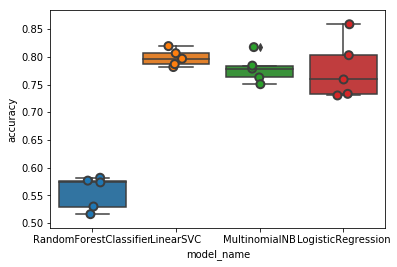

In [162]:
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import LinearSVC
from sklearn.model_selection import cross_val_score
models = [
    RandomForestClassifier(n_estimators=200, max_depth=3, random_state=0),
    LinearSVC(),
    MultinomialNB(),
    LogisticRegression(random_state=0),
]
CV = 5
cv_df = pd.DataFrame(index=range(CV * len(models)))
entries = []
for model in models:
  model_name = model.__class__.__name__
  accuracies = cross_val_score(model, features, labels, scoring='f1_weighted', cv=CV)
  for fold_idx, accuracy in enumerate(accuracies):
    entries.append((model_name, fold_idx, accuracy))
cv_df = pd.DataFrame(entries, columns=['model_name', 'fold_idx', 'accuracy'])
import seaborn as sns
sns.boxplot(x='model_name', y='accuracy', data=cv_df)
sns.stripplot(x='model_name', y='accuracy', data=cv_df, 
              size=8, jitter=True, edgecolor="gray", linewidth=2)
plt.show()

In [163]:
print(cv_df.groupby('model_name').accuracy.mean())

c = "nao recebi o produto no recebi uma justificativa do vendedor. entrei em contato mas at√© agora n√£o obtive uma resposta. "
print(clf.predict(tfidf_transformer.transform(count_vect.transform([c]))))



model_name
LinearSVC                 0.798185
LogisticRegression        0.776867
MultinomialNB             0.778770
RandomForestClassifier    0.555413
Name: accuracy, dtype: float64
['negative']


In [157]:
reviewsm_valid.head()

,review_id,order_id,review_score,review_comment_title,review_comment_message,review_creation_date,review_answer_timestamp,concat,delivery_pos,quality_pos,...,quality,quantity_parcial,wrong_item,cs,review_comment,delivery_categories,quality_categories,quantity_categories,wrong_item_categories,quant_wrong_categories
380,87372d62475088a990fb966efae35790,f31e4f9ef9c06d4ec8fe2cb66c65e384,4.0,,"Demorou um pouco pra chegar, mas dentro do pra...",10/13/17 0:00,10/16/17 1:28,"It took a while to get there, but on time. The...",1.0,1.0,...,0.0,0.0,0.0,0.0,demorou um pouco pra chegar mas dentro do praz...,positive,positive,no_mention,no_mention,no_mention
381,0c6c7526f336820905dea6cd1bd49750,50cfface6cf1a49abc9e3aeb6f13d995,5.0,,Produto maravilhoso Adorei Eu recomendo podem ...,8/30/17 0:00,8/30/17 21:05,Wonderful product I loved I recommend you can ...,0.0,1.0,...,0.0,0.0,0.0,0.0,produto maravilhoso adorei eu recomendo podem ...,no_mention,positive,no_mention,no_mention,no_mention
382,7dd1763b8f42187e34f7a4632e49a814,878a0241d449fe7ea1bec1cf145b9c9b,5.0,,"Estou ainda esperando, por favor me ajude ai",6/28/17 0:00,6/28/17 15:05,"I'm still waiting, please help me there",0.0,0.0,...,0.0,0.0,0.0,0.0,estou ainda esperando por favor me ajude ai,negative,no_mention,no_mention,no_mention,no_mention
383,d0e8ebec0d960128c72f7d26b459be6f,e35e63b98848e494f75ce91dbef9cf11,5.0,Muito bom os produtos,Estou muito satisfeito com os produtos. Parabâ...,7/5/18 0:00,7/8/18 18:26,I am very satisfied with the products. Congrat...,0.0,1.0,...,0.0,0.0,0.0,0.0,muito bom os produtos estou muito satisfeito c...,no_mention,positive,no_mention,no_mention,no_mention
384,9606d8b7067243de23357ae1970a8a26,304e7fc7db4a67a8ab0403ce4eb42ae0,5.0,,Chegou no prazo e parece ser bem bonito! Ainda...,8/4/17 0:00,8/5/17 13:12,Arrived on time and looks pretty good! I have ...,1.0,0.0,...,0.0,0.0,0.0,0.0,chegou no prazo e parece ser bem bonito ainda ...,positive,no_mention,no_mention,no_mention,no_mention


In [178]:
X_val

380    demorou um pouco pra chegar mas dentro do praz...
381    produto maravilhoso adorei eu recomendo podem ...
382          estou ainda esperando por favor me ajude ai
383    muito bom os produtos estou muito satisfeito c...
384    chegou no prazo e parece ser bem bonito ainda ...
385    nâˆšâo recebi o produto na data prevista envie...
386                                     âˆšãtimo produto
387    efetuei o pagamento do boleto mas objeto nâˆšâ...
388    perfeito entrega muitâˆšâ ssimo antes do previ...
389                      chegou antes do prazo informado
390    produto nâˆšâo chegou e tenho informaâˆšãÿâˆšâ...
391                               veio tâˆšâo râˆšâpido 
392    muito satisfeito o produto chegou 15 antes do ...
393                                     estou satisfeito
394                  entregue antes do prazo estipulado 
395                                      otimo muito bom
396                                   otimo ok recomendo
397    exatamente o que esperav

In [168]:
from sklearn import metrics
X_val, y_val = reviewsm_valid['review_comment'], reviewsm_valid['delivery_categories']

count_vect = CountVectorizer(ngram_range=(1, 3))
X_val_counts = count_vect.fit_transform(X_val)
tfidf_transformer = TfidfTransformer()
X_val_tfidf = tfidf_transformer.fit_transform(X_val_counts)





clf = LinearSVC()
clf.fit(X_train_tfidf, y_train)


pred = clf.predict(X_val_tfidf)
score = metrics.accuracy_score(y_val, pred)
print('Accuracy score\n', score)










ValueError: X has 2029 features per sample; expecting 10451

In [ ]:
#X_train, X_test, y_train, y_test = train_test_split(reviewsm_pos_n['review_comment'], reviewsm_pos_n['delivery_categories'], random_state = 0)


##quality-categories

In [164]:
def mod_select(cat):
    tfidf = TfidfVectorizer(sublinear_tf=True, min_df=5, norm='l2', encoding='latin-1', ngram_range=(1, 3), stop_words='english')
    features = tfidf.fit_transform(reviewsm_pos_n.review_comment).toarray()
    labels = reviewsm_pos_n[cat]
    features.shape
    X_train, X_test, y_train, y_test = train_test_split(reviewsm_pos_n['review_comment'], reviewsm_pos_n[cat], random_state = 0)
    count_vect = CountVectorizer(ngram_range=(1, 3))
    X_train_counts = count_vect.fit_transform(X_train)
    tfidf_transformer = TfidfTransformer()
    X_train_tfidf = tfidf_transformer.fit_transform(X_train_counts)
    clf = MultinomialNB().fit(X_train_tfidf, y_train)
    
    
    models = [
        RandomForestClassifier(n_estimators=200, max_depth=3, random_state=0),
        LinearSVC(),
        MultinomialNB(),
        LogisticRegression(random_state=0),
    ]
    CV = 5
    cv_df = pd.DataFrame(index=range(CV * len(models)))
    entries = []
    for model in models:
      model_name = model.__class__.__name__
      accuracies = cross_val_score(model, features, labels, scoring='f1_weighted', cv=CV)
      for fold_idx, accuracy in enumerate(accuracies):
        entries.append((model_name, fold_idx, accuracy))
    cv_df = pd.DataFrame(entries, columns=['model_name', 'fold_idx', 'accuracy'])
    import seaborn as sns
    sns.boxplot(x='model_name', y='accuracy', data=cv_df)
    sns.stripplot(x='model_name', y='accuracy', data=cv_df, 
                  size=8, jitter=True, edgecolor="gray", linewidth=2)
    plt.show()
    
    print(cv_df.groupby('model_name').accuracy.mean())



/anaconda3/lib/python3.7/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
/anaconda3/lib/python3.7/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
/anaconda3/lib/python3.7/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
/anaconda3/lib/python3.7/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


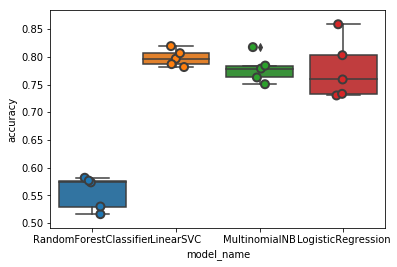

model_name
LinearSVC                 0.798185
LogisticRegression        0.776867
MultinomialNB             0.778770
RandomForestClassifier    0.555413
Name: accuracy, dtype: float64


In [177]:
mod_select('delivery_categories')

In [ ]:
predict_del = clf.predict(count_vect.transform(["rapido"]))

In [182]:
reviewsm_pos_n['predict_del'] =  clf.predict(count_vect.transform(["rapido"]))

ValueError: Length of values does not match length of index

/anaconda3/lib/python3.7/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
/anaconda3/lib/python3.7/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
/anaconda3/lib/python3.7/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
/anaconda3/lib/python3.7/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
/anaconda3/lib/python3.7/site-packages/sklearn/metrics/classification.py:113

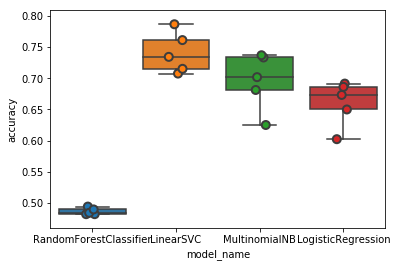

model_name
LinearSVC                 0.741159
LogisticRegression        0.660693
MultinomialNB             0.695783
RandomForestClassifier    0.486212
Name: accuracy, dtype: float64


In [166]:
mod_select('quality_categories')

/anaconda3/lib/python3.7/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
/anaconda3/lib/python3.7/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
/anaconda3/lib/python3.7/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
/anaconda3/lib/python3.7/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
/anaconda3/lib/python3.7/site-packages/sklearn/metrics/classification.py:113

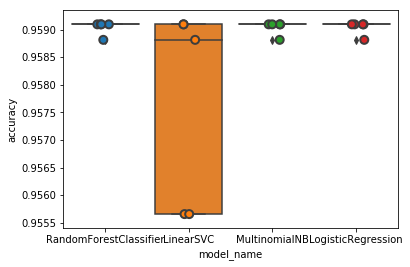

model_name
LinearSVC                 0.957664
LogisticRegression        0.959038
MultinomialNB             0.959038
RandomForestClassifier    0.959038
Name: accuracy, dtype: float64


In [167]:
mod_select('wrong_item_categories')

/anaconda3/lib/python3.7/site-packages/sklearn/model_selection/_split.py:605: Warning: The least populated class in y has only 1 members, which is too few. The minimum number of members in any class cannot be less than n_splits=5.
  % (min_groups, self.n_splits)), Warning)
/anaconda3/lib/python3.7/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
/anaconda3/lib/python3.7/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
/anaconda3/lib/python3.7/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
/anaconda3/lib/python3.7/site-pac

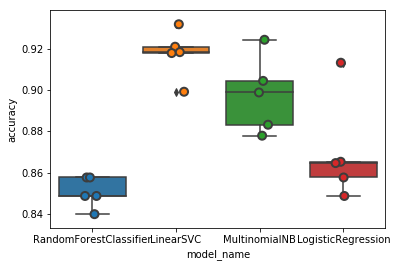

model_name
LinearSVC                 0.917573
LogisticRegression        0.869850
MultinomialNB             0.897678
RandomForestClassifier    0.850491
Name: accuracy, dtype: float64


In [168]:
mod_select('quantity_categories') # 


/anaconda3/lib/python3.7/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
/anaconda3/lib/python3.7/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
/anaconda3/lib/python3.7/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
/anaconda3/lib/python3.7/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
/anaconda3/lib/python3.7/site-packages/sklearn/metrics/classification.py:113

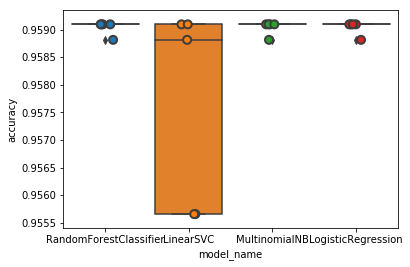

model_name
LinearSVC                 0.957664
LogisticRegression        0.959038
MultinomialNB             0.959038
RandomForestClassifier    0.959038
Name: accuracy, dtype: float64


In [169]:
mod_select('wrong_item_categories')

# quality_categories

In [170]:
X_train, X_test, y_train, y_test = train_test_split(reviewsm_pos_n['review_comment'], reviewsm_pos_n['quality_categories'], random_state = 0)
count_vect = CountVectorizer(ngram_range=(1, 3))
X_train_counts = count_vect.fit_transform(X_train)
tfidf_transformer = TfidfTransformer()
X_train_tfidf = tfidf_transformer.fit_transform(X_train_counts)
clf = MultinomialNB().fit(X_train_tfidf, y_train)
   

/anaconda3/lib/python3.7/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
/anaconda3/lib/python3.7/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
/anaconda3/lib/python3.7/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
/anaconda3/lib/python3.7/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


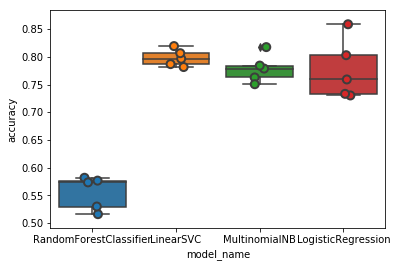

In [171]:
models = [
    RandomForestClassifier(n_estimators=200, max_depth=3, random_state=0),
    LinearSVC(),
    MultinomialNB(),
    LogisticRegression(random_state=0),
]
CV = 5
cv_df = pd.DataFrame(index=range(CV * len(models)))
entries = []
for model in models:
  model_name = model.__class__.__name__
  accuracies = cross_val_score(model, features, labels, scoring='f1_weighted', cv=CV)
  for fold_idx, accuracy in enumerate(accuracies):
    entries.append((model_name, fold_idx, accuracy))
cv_df = pd.DataFrame(entries, columns=['model_name', 'fold_idx', 'accuracy'])
import seaborn as sns
sns.boxplot(x='model_name', y='accuracy', data=cv_df)
sns.stripplot(x='model_name', y='accuracy', data=cv_df, 
              size=8, jitter=True, edgecolor="gray", linewidth=2)
plt.show()

In [172]:
print(clf.predict(count_vect.transform(["Entrega perfeitaMuito bom. muito cheiroso."])))

['no_mention']


In [173]:
c = "Adorei kjhkj"
print(clf.predict(tfidf_vectorizer.fit_transform([c])))



NameError: name 'tfidf_vectorizer' is not defined

In [174]:
#c= "gjgh iu hiu yiu"

c = "O produto chegou correto. O problema foi a demora na entrega."
#c =count_vect.transform([c])
c = tfidf_vectorizer.fit_transform(c)

NameError: name 'tfidf_vectorizer' is not defined

In [175]:
print(clf.predict(c))

TypeError: Cannot cast array data from dtype('float64') to dtype('<U32') according to the rule 'safe'

# Preprocessing,
Removing punctuation, stopwords. Stemming 

In [176]:
from nltk.stem.porter import PorterStemmer
stemmer = nltk.stem.RSLPStemmer()
stopwords = nltk.corpus.stopwords.words('portuguese')
#stopwords = set(stopwords) - set(('não'))
#noise_words = ['recebemo', 'recebimento', 'nan','produto','correio', 'entregu','recomendo','compra', 'comprar','recebi', 'compra', 'entregu', 'entrega', 'entregoa', 'comprei',  'veio', 'é', 'pedido' , 'chegou', 'apena']
#recebemo" + 0.009*"funciona" + 0.009*"recebimento"
#" + 0.025*"veio" + 0.024*"é" + 0.017*"entregu" + 0.013*"pedido" + 0.013*"chegou" + 0.011*"apena" + 0.011*"qualidad" + 0.010*"recomendo"



reviews['review_comment_t']  = reviews['review_comment'] .str.replace('[^\w\s]','')
reviews['review_comment_t']  = reviews['review_comment_t'] .str.lower().str.split()
#reviews['review_comment_t'] =  reviews['review_comment_t'].apply(lambda x: [item for item in x if item not in stopwords ])

#reviews['review_comment_t'] =  reviews['review_comment_t'].apply(lambda x: [item for item in x if item not in noise_words ])

reviews['review_comment_t_stem'] = reviews['review_comment_t'].apply(lambda x: [stemmer.stem(y) for y in x])
reviews[reviews['review_score']<3][['review_comment','review_comment_t']].head()


KeyError: 'review_comment'

In [13]:
type(stopwords)

list

In [14]:
reviews[reviews['review_score']<3][['review_comment','review_comment_t']]

,review_comment,review_comment_t
5,,[]
16,gostaria de saber o que houve sempre recebi e ...,"[gostaria, de, saber, o, que, houve, sempre, r..."
19,não chegou meu produto péssimo,"[não, chegou, meu, produto, péssimo]"
29,não gostei comprei gato por lebre,"[não, gostei, comprei, gato, por, lebre]"
32,sempre compro pela internet e a entrega ocorre...,"[sempre, compro, pela, internet, e, a, entrega..."
39,nada de chegar o meu pedido,"[nada, de, chegar, o, meu, pedido]"
40,,[]
41,,[]
51,recebi somente 1 controle midea split estilo f...,"[recebi, somente, 1, controle, midea, split, e..."
68,o produto não chegou no prazo estipulado e cau...,"[o, produto, não, chegou, no, prazo, estipulad..."


In [234]:
#não recebi 
#não fora entregue
#recebi somente - only recieved 
#so recebi - only recieved 
#reviews['review_pos_neg'] = reviews['review_score'] 
#reviews.head()

#reviews_only['review_pos_neg'] ([0, 1, 2, 3, 4, 5], ['neg', 'neg', 'neg', 'neg', 'pos', 'pos'])
#reviews['review_pos_neg'] = reviews['review_pos_neg'].map({1: 'neg', 2: 'neg', 3: 'neg', 4: 'neg', 5:'pos' })
#reviews.head()

In [235]:
processed_docs = reviews['review_comment_t_stem']
print(len(processed_docs))
print(processed_docs[:40].head())


43482
3                                                                                                             [nan, receb, bem, ant, do, praz, estipul]
4                                                        [nan, parabém, loj, lannist, ador, compr, pel, internet, segur, e, prát, a, tod, feliz, pásco]
9     [recom, aparelh, efici, no, sit, a, marc, do, est, impress, com, 3desinfec, e, ao, cheg, com, outr, nomeatual, corret, uma, vez, que, é, o, mesm]
12                                                                                                      [nan, mas, um, pouc, travandopel, val, ta, boa]
15                                                                                      [sup, recom, vend, confi, produt, ok, e, entreg, ant, do, praz]
Name: review_comment_t_stem, dtype: object


Preprocess the  revie wcomment, saving the results as ‘processed_docs’

In [236]:
processed_docs_pos = reviews[reviews['review_score']>3]['review_comment_t_stem']
processed_docs[:40]
#len(processed_docs)

3                                                                                                                                                  [nan, receb, bem, ant, do, praz, estipul]
4                                                                                             [nan, parabém, loj, lannist, ador, compr, pel, internet, segur, e, prát, a, tod, feliz, pásco]
9                                          [recom, aparelh, efici, no, sit, a, marc, do, est, impress, com, 3desinfec, e, ao, cheg, com, outr, nomeatual, corret, uma, vez, que, é, o, mesm]
12                                                                                                                                           [nan, mas, um, pouc, travandopel, val, ta, boa]
15                                                                                                                           [sup, recom, vend, confi, produt, ok, e, entreg, ant, do, praz]
16                                                     

In [237]:
import gensim
dictionary = gensim.corpora.Dictionary(processed_docs_pos)
count = 0
for k, v in dictionary.iteritems():
    print(k, v)
    count += 1
    if count > 10:
        break

0 ant
1 bem
2 do
3 estipul
4 nan
5 praz
6 receb
7 a
8 ador
9 compr
10 e


In [238]:
dictionary.filter_extremes(no_below=15, no_above=0.5, keep_n=100000)

In [239]:
bow_corpus = [dictionary.doc2bow(doc) for doc in processed_docs_pos]
bow_corpus[4310]

[(23, 1), (38, 1), (61, 1), (73, 1), (123, 1), (140, 1)]

In [240]:
from gensim import corpora, models
tfidf = models.TfidfModel(bow_corpus)
corpus_tfidf = tfidf[bow_corpus]
from pprint import pprint
for doc in corpus_tfidf:
    pprint(doc)
    break

[(0, 0.2575331461086131),
 (1, 0.37085552644115516),
 (2, 0.20223671019331663),
 (3, 0.7281890716648343),
 (4, 0.21591235351900354),
 (5, 0.42233363792081446)]


In [241]:
lda_model = gensim.models.LdaMulticore(bow_corpus, num_topics=4, id2word=dictionary, passes=2, workers=2)

In [242]:
lda_model = gensim.models.LdaMulticore(bow_corpus, num_topics=4, id2word=dictionary, passes=2, workers=2)
for idx, topic in lda_model.print_topics(-1):
    print('Topic: {} \nWords: {}'.format(idx, topic))

Topic: 0 
Words: 0.064*"produt" + 0.042*"e" + 0.042*"de" + 0.037*"entreg" + 0.037*"qual" + 0.031*"praz" + 0.024*"com" + 0.024*"o" + 0.024*"a" + 0.023*"do"
Topic: 1 
Words: 0.087*"do" + 0.078*"ant" + 0.073*"praz" + 0.052*"cheg" + 0.050*"produt" + 0.042*"entreg" + 0.033*"o" + 0.026*"e" + 0.025*"bem" + 0.023*"muit"
Topic: 2 
Words: 0.035*"o" + 0.033*"produt" + 0.030*"a" + 0.028*"ótim" + 0.025*"que" + 0.025*"com" + 0.025*"e" + 0.024*"de" + 0.022*"compr" + 0.019*"não"
Topic: 3 
Words: 0.089*"muit" + 0.077*"recom" + 0.076*"bom" + 0.069*"produt" + 0.053*"entreg" + 0.044*"e" + 0.041*"sup" + 0.033*"rápid" + 0.026*"o" + 0.021*"tud"


In [243]:
lda_model_tfidf = gensim.models.LdaMulticore(corpus_tfidf, num_topics=4, id2word=dictionary, passes=2, workers=4)
for idx, topic in lda_model_tfidf.print_topics(-1):
    print('Topic: {} Word: {}'.format(idx, topic))

Topic: 0 Word: 0.071*"bom" + 0.042*"muit" + 0.016*"compr" + 0.015*"a" + 0.012*"produt" + 0.011*"o" + 0.010*"que" + 0.010*"recom" + 0.009*"recomend" + 0.009*"e"
Topic: 1 Word: 0.048*"recom" + 0.044*"praz" + 0.039*"entreg" + 0.039*"ant" + 0.038*"do" + 0.031*"produt" + 0.029*"rápid" + 0.029*"cheg" + 0.026*"sup" + 0.022*"bom"
Topic: 2 Word: 0.029*"ok" + 0.028*"gost" + 0.028*"tud" + 0.023*"satisfeit" + 0.018*"muit" + 0.017*"corret" + 0.017*"cert" + 0.016*"rap" + 0.016*"produt" + 0.016*"o"
Topic: 3 Word: 0.062*"ótim" + 0.057*"excel" + 0.052*"otim" + 0.030*"boa" + 0.025*"produt" + 0.024*"atend" + 0.020*"qual" + 0.020*"loj" + 0.020*"de" + 0.016*"recom"


In [244]:
pd.set_option('max_colwidth', 800)
processed_docs_neg = reviews[reviews['review_score']<2]['review_comment_t_stem']
processed_docs_neg[:40]
#len(processed_docs)

19                                                                                                                                                                    [não, cheg, meu, produt, péss]
29                                                                                                                                                           [nan, não, gost, compr, gat, por, lebr]
32                                [nan, sempr, compr, pel, internet, e, a, entreg, ocorr, ant, do, praz, combin, que, acredit, ser, o, máx, no, stark, máx, já, se, esgot, aind, não, receb, produt]
39                                                                                                                                                                 [nan, nad, de, cheg, o, meu, ped]
51                                                                                            [nan, receb, soment, 1, control, mide, split, estil, falt, control, remot, par, ar, condicion, consul]
68            [

In [245]:
import gensim
dictionary = gensim.corpora.Dictionary(processed_docs_neg)
count = 0
for k, v in dictionary.iteritems():
    print(k, v)
    count += 1
    if count > 10:
        break

0 cheg
1 meu
2 não
3 produt
4 péss
5 compr
6 gat
7 gost
8 lebr
9 nan
10 por


In [246]:
#featuresets[100:], featuresets[:100]

In [247]:
bow_corpus = [dictionary.doc2bow(doc) for doc in processed_docs_neg]
print(bow_corpus[9999])
print(reviews.review_comment_t_stem.iloc[4310])
print(reviews.review_comment.iloc[9999])

IndexError: list index out of range

In [248]:
for doc in corpus_tfidf:
    pprint(doc)
    break

[(0, 0.2575331461086131),
 (1, 0.37085552644115516),
 (2, 0.20223671019331663),
 (3, 0.7281890716648343),
 (4, 0.21591235351900354),
 (5, 0.42233363792081446)]


In [249]:
lda_model = gensim.models.LdaMulticore(bow_corpus, num_topics=14, id2word=dictionary, passes=2, workers=2)
for idx, topic in lda_model.print_topics(-1):
    print('Topic: {} \nWords: {}'.format(idx, topic))

Topic: 0 
Words: 0.058*"nan" + 0.037*"não" + 0.035*"de" + 0.030*"produt" + 0.027*"e" + 0.024*"o" + 0.018*"meu" + 0.018*"compr" + 0.017*"mais" + 0.016*"a"
Topic: 1 
Words: 0.051*"nan" + 0.045*"produt" + 0.041*"o" + 0.027*"não" + 0.024*"com" + 0.023*"e" + 0.021*"a" + 0.018*"receb" + 0.017*"entreg" + 0.015*"compr"
Topic: 2 
Words: 0.061*"não" + 0.053*"nan" + 0.047*"receb" + 0.040*"produt" + 0.038*"o" + 0.029*"entreg" + 0.028*"e" + 0.018*"foi" + 0.017*"de" + 0.016*"aind"
Topic: 3 
Words: 0.032*"nan" + 0.030*"compr" + 0.027*"produt" + 0.027*"o" + 0.024*"e" + 0.023*"que" + 0.022*"não" + 0.020*"a" + 0.017*"com" + 0.015*"de"
Topic: 4 
Words: 0.033*"nan" + 0.033*"produt" + 0.028*"o" + 0.027*"e" + 0.023*"não" + 0.022*"compr" + 0.021*"de" + 0.019*"a" + 0.019*"um" + 0.018*"com"
Topic: 5 
Words: 0.041*"nan" + 0.025*"compr" + 0.021*"produt" + 0.021*"não" + 0.019*"entreg" + 0.019*"de" + 0.019*"do" + 0.018*"a" + 0.018*"uma" + 0.016*"e"
Topic: 6 
Words: 0.048*"nan" + 0.036*"e" + 0.035*"não" + 0.031*"re

In [250]:
lda_model_tfidf = gensim.models.LdaMulticore(corpus_tfidf, num_topics=14, id2word=dictionary, passes=2, workers=4)
for idx, topic in lda_model_tfidf.print_topics(-1):
    print('Topic: {} Word: {}'.format(idx, topic))

Topic: 0 Word: 0.036*"correi" + 0.026*"brasil" + 0.024*"3590" + 0.023*"err" + 0.019*"cheg" + 0.017*"par" + 0.013*"já" + 0.013*"soment" + 0.012*"se" + 0.012*"nan"
Topic: 1 Word: 0.158*"até" + 0.098*"cas" + 0.082*"mor" + 0.043*"soment" + 0.033*"stark" + 0.031*"par" + 0.027*"péss" + 0.024*"folh" + 0.020*"cheg" + 0.019*"apen"
Topic: 2 Word: 0.016*"se" + 0.015*"soment" + 0.015*"máx" + 0.014*"não" + 0.013*"esper" + 0.013*"moment" + 0.013*"péss" + 0.013*"par" + 0.013*"nan" + 0.012*"já"
Topic: 3 Word: 0.026*"ant" + 0.021*"caus" + 0.014*"lebr" + 0.013*"moment" + 0.013*"ocorr" + 0.012*"detest" + 0.012*"soment" + 0.012*"se" + 0.011*"mor" + 0.011*"nan"
Topic: 4 Word: 0.072*"ar" + 0.029*"agor" + 0.027*"aind" + 0.023*"stark" + 0.022*"mor" + 0.018*"lebr" + 0.016*"os" + 0.014*"nan" + 0.014*"soment" + 0.014*"sincron"
Topic: 5 Word: 0.085*"for" + 0.046*"mor" + 0.025*"até" + 0.021*"não" + 0.019*"soment" + 0.019*"o" + 0.019*"mide" + 0.018*"tec" + 0.018*"nan" + 0.017*"meu"
Topic: 6 Word: 0.115*"stark" + 0.

In [251]:
for index, score in sorted(lda_model_tfidf[bow_corpus[100]], key=lambda tup: -1*tup[1]):
    print("\nScore: {}\t \nTopic: {}".format(score, lda_model_tfidf.print_topic(index, 10)))


Score: 0.2756527364253998	 
Topic: 0.026*"ant" + 0.021*"caus" + 0.014*"lebr" + 0.013*"moment" + 0.013*"ocorr" + 0.012*"detest" + 0.012*"soment" + 0.012*"se" + 0.011*"mor" + 0.011*"nan"

Score: 0.2531431019306183	 
Topic: 0.115*"stark" + 0.044*"split" + 0.019*"entreg" + 0.019*"gat" + 0.015*"par" + 0.014*"sei" + 0.014*"não" + 0.014*"péss" + 0.013*"soment" + 0.013*"se"

Score: 0.21749481558799744	 
Topic: 0.016*"se" + 0.014*"iss" + 0.013*"ter" + 0.013*"lebr" + 0.012*"gat" + 0.012*"compr" + 0.012*"máx" + 0.011*"soment" + 0.011*"ser" + 0.011*"nan"

Score: 0.1804603785276413	 
Topic: 0.034*"no" + 0.021*"par" + 0.018*"nan" + 0.016*"soment" + 0.015*"se" + 0.014*"péss" + 0.014*"gat" + 0.014*"stark" + 0.013*"não" + 0.012*"escolh"

Score: 0.04851093515753746	 
Topic: 0.158*"até" + 0.098*"cas" + 0.082*"mor" + 0.043*"soment" + 0.033*"stark" + 0.031*"par" + 0.027*"péss" + 0.024*"folh" + 0.020*"cheg" + 0.019*"apen"


In [253]:
bow_corpus[100]


[(2, 1),
 (9, 1),
 (11, 1),
 (17, 1),
 (18, 1),
 (24, 1),
 (28, 1),
 (33, 1),
 (34, 1),
 (36, 1),
 (71, 1),
 (72, 1),
 (77, 1),
 (98, 1),
 (122, 1),
 (147, 1),
 (179, 1),
 (217, 1),
 (426, 1),
 (485, 1),
 (486, 1),
 (487, 1),
 (488, 1),
 (489, 1),
 (490, 1)]

In [254]:
bow_doc_9999 = bow_corpus[100]
for i in range(len(bow_doc_9999)):
    print("Word {} (\"{}\") appears {} time.".format(bow_doc_9999[i][0], 
                                               dictionary[bow_doc_9999[i][0]], 
bow_doc_9999[i][1]))
print(reviews['review_comment'][100])

Word 2 ("não") appears 1 time.
Word 9 ("nan") appears 1 time.
Word 11 ("a") appears 1 time.
Word 17 ("e") appears 1 time.
Word 18 ("entreg") appears 1 time.
Word 24 ("o") appears 1 time.
Word 28 ("que") appears 1 time.
Word 33 ("stark") appears 1 time.
Word 34 ("de") appears 1 time.
Word 36 ("ped") appears 1 time.
Word 71 ("mal") appears 1 time.
Word 72 ("muit") appears 1 time.
Word 77 ("sem") appears 1 time.
Word 98 ("vend") appears 1 time.
Word 122 ("eu") appears 1 time.
Word 147 ("loj") appears 1 time.
Word 179 ("tiv") appears 1 time.
Word 217 ("cancel") appears 1 time.
Word 426 ("porc") appears 1 time.
Word 485 ("descar") appears 1 time.
Word 486 ("duer") appears 1 time.
Word 487 ("escolh") appears 1 time.
Word 488 ("paec") appears 1 time.
Word 489 ("seu") appears 1 time.
Word 490 ("vergonh") appears 1 time.
nan Satisfeito


In [ ]:
#bow_doc_4310 = bow_corpus[4310]
#for i in range(len(bow_doc_4310)):
    #print("Word {} (\"{}\") appears {} time.".format(bow_doc_4310[i][0], 
                                              # dictionary[bow_doc_4310[i][0]], 
#bow_doc_4310[i][1]))

In [ ]:



#bow_vector = dictionary.doc2bow(['ja', 'devolv', 'poi', 'defeito', 'segurar', 'carga'])
bow_vector = dictionary.doc2bow(["prazo","reembols","entreg","dua","seman","feit","após"])


for index, score in sorted(lda_model[bow_vector], key=lambda tup: -1*tup[1]):
    print("Score: {}\t Topic: {}".format(score, lda_model.print_topic(index, 5)))

In [ ]:
bow_vector = dictionary.doc2bow(["prazo","reembols","entreg","dua","seman","feit","após"])


for index, score in sorted(lda_model[bow_vector], key=lambda tup: -1*tup[1]):
    print("Score: {}\t Topic: {}".format(score, lda_model.print_topic(index, 5)))

In [ ]:
bow_vector = dictionary.doc2bow(['ja', 'devolv', 'poi', 'defeito', 'segurar', 'carga'])
for index, score in sorted(lda_model[bow_vector], key=lambda tup: -1*tup[1]):
    print("Score: {}\t Topic: {}".format(score, lda_model.print_topic(index, 5)))

In [ ]:
---------------*************--------------------

In [ ]:
#df = reviews_only[['review_comment_message', 'review_score']]

#classification
df = reviews[['review_comment_t_stem', 'review_pos_neg']]



In [ ]:

df.apply(tuple, axis=1)

df.head()

In [15]:
sum = []
for wlist in reviews['review_comment_t_stem']:
  sum = sum + wlist

In [16]:
sum

['receb',
 'bem',
 'ant',
 'do',
 'praz',
 'estipul',
 'parabém',
 'loj',
 'lannist',
 'ador',
 'compr',
 'pel',
 'internet',
 'segur',
 'e',
 'prát',
 'a',
 'tod',
 'feliz',
 'pásco',
 'recom',
 'aparelh',
 'efici',
 'no',
 'sit',
 'a',
 'marc',
 'do',
 'est',
 'impress',
 'com',
 '3desinfec',
 'e',
 'ao',
 'cheg',
 'com',
 'outr',
 'nomeatual',
 'corret',
 'uma',
 'vez',
 'que',
 'é',
 'o',
 'mesm',
 'mas',
 'um',
 'pouc',
 'travandopel',
 'val',
 'ta',
 'boa',
 'sup',
 'recom',
 'vend',
 'confi',
 'produt',
 'ok',
 'e',
 'entreg',
 'ant',
 'do',
 'praz',
 'gost',
 'de',
 'sab',
 'o',
 'que',
 'houv',
 'sempr',
 'receb',
 'e',
 'ess',
 'compr',
 'agor',
 'me',
 'decpcion',
 'não',
 'cheg',
 'meu',
 'produt',
 'péss',
 'ótim',
 'loj',
 'not',
 '10',
 'obrig',
 'pel',
 'atença',
 'amim',
 'dispens',
 'a',
 'compr',
 'foi',
 'realiz',
 'facil',
 'entreg',
 'efetu',
 'muit',
 'ant',
 'do',
 'praz',
 'dad',
 'o',
 'produt',
 'já',
 'começ',
 'a',
 'ser',
 'us',
 'e',
 'até',
 'o',
 'pres'

In [17]:
#mergedlist = list(sum)
documents = [tuple(x) for x in df.values]


NameError: name 'df' is not defined

In [ ]:
from itertools import chain
all_words = nltk.FreqDist(sum)
#word_features = list(all_words)[:600]
print(type(dict(all_words).keys()))
d=dict(all_words).copy().keys()
word_features ={x for x in chain(dict(all_words).copy().keys()) if x}

In [ ]:
#pd.options.display.max_colwidth = 1000
#print(reviews[reviews['review_comment'].str.contains("atrás")]['review_comment'].shape)
#reviews[reviews['review_comment'].str.contains("atrás")]['review_comment'].head(10)
#mixed

In [ ]:
def document_features(document):
    document_words = set(document)
    features = {}
    for word in word_features:
        features['contains({})'.format(word)] = (word in document_words)
    return features

#random.shuffle(documents)


In [ ]:
#from google.colab import files
#word_df = pd.DataFrame(word_features)
#word_df.to_csv('out.csv', index=False, header=False)
#files.download('out.csv') 

In [ ]:
featuresets = [(document_features(d), c) for (d,c) in documents]
train_set, test_set = featuresets[100:], featuresets[:100]
classifier = nltk.NaiveBayesClassifier.train(train_set)

In [ ]:
print('Accuracy: ', nltk.classify.accuracy(classifier, test_set))


In [ ]:
print(classifier)
print(classifier.show_most_informative_features(400))
print(classifier.most_informative_features(400))




#Manual Check
Checkig comments that may inducate a reason fora negative or positive review -  quality, quantity, delivery, packaging 

In [ ]:



#from google.colab import files
#rv = pd.DataFrame(rv)
#rv.to_csv('out.csv', index=False, header=False)
#files.download('out.csv') 





quality_i = ["defeito", 'menor','branca','quebrado', 'diferente', 'foto', "descrição",'falso', 'falsificado','condiz', 'riscos', 'proteção','danificado']
delivery_i = ["rapido", 'antes','depois', 'prazo de entrega', 'riscos', 'proteção','danificado']



quality_i = [stemmer.stem(word) for word in qualityl]



In [ ]:
quality_i = ["defeito", 'diâmetro', 'bonito', 'menor','branca','quebrado', 'diferente', 'foto', "descrição",'falso', 'falsificado','condiz', 'riscos', 'proteção','danificado']

quality_i

In [353]:
 #reviews['review_comment_t_stem_joined']=   "-".join(reviews['review_comment_t_stem'])
reviews['review_comment_t_stem_joined']= reviews['review_comment_t'].apply(lambda x: ' '.join(x))

reviews['review_comment_t_stem_joined'].head(5)

3                                                                      nan recebi bem antes prazo estipulado
4                     nan parabéns lojas lannister adorei comprar internet seguro prático todos feliz páscoa
9     recomendo aparelho eficiente site marca impresso 3desinfector chegar outro nomeatualizar correta vez é
12                                                                       nan pouco travandopelo valor ta boa
15                                         super recomendo vendedor confiável produto ok entrega antes prazo
Name: review_comment_t_stem_joined, dtype: object

In [ ]:
quality_i = str.join('|', [stemmer.stem(word) for word in quality_i])

In [ ]:
quality_i

In [ ]:
reviews['quality'] = reviews['review_comment_t_stem_joined'].str.contains(quality_i)
#reviews[reviews['quality']==True]['review_comment']

In [ ]:
reviews[reviews['quality']==True]['review_comment'].shape

In [ ]:
pd.set_option('max_colwidth', 800)
reviews.head()

In [ ]:
reviews[reviews['review_comment'].str.contains('prazo de entrega')]['review_comment'].shape

#reviews['review_comment'].to_csv()

In [ ]:
reviews[
       reviews['review_comment'].str.contains( 'total')
             |
        reviews['review_comment'].str.contains( 'falta')
           |
        reviews['review_comment'].str.contains( 'incompleto')
       |
    reviews['review_comment'].str.contains( 'parcial')
        
          
       
       ]['review_comment']

In [ ]:
reviews[reviews['review_comment_t_stem_joined'].str.contains('incompleto')]['review_comment'].shape
reviews[reviews['review_comment_t_stem_joined'].str.contains('parcial')]['review_comment'].shape





In [ ]:
quantity _i = ['um',  'dois',  'três',  'quatro',  'cinco', 'cinco', 'sete' oito nove dez onze doze treze quinze dezesseis dezessete dezoito dezenove

In [ ]:

# sample for speed
raw_df = reviews.sample(frac=0.1,  replace=False)
print (raw_df.shape)
# grab review text
raw = list(raw_df['review_comment_t_stem'])
print (len(raw))

sentences = raw
#print(sentences)
from gensim.models import Word2Vec

model = Word2Vec(sentences=sentences, # tokenized senteces, list of list of strings
                 size=3000,  # size of embedding vectors
                 workers=4, # how many threads?
                 min_count=2, # minimum frequency per token, filtering rare words
                 sample=0.05, # weight of downsampling common words
                 sg = 1, # should we use skip-gram? if 0, then cbow
                 iter=5,
                 hs = 0
        )

X = model[model.wv.vocab]


In [ ]:
 [nltk.tag.str2tuple(t) for t in sent.split()]

Now that we have words inducating quantity quality delivery are found we run words embedding to see more ideas for key word inducators 

In [ ]:
print (model.wv.most_similar('demora'))#delay



previsão
atraso
correta
pontual

In [ ]:
stemmer.stem('prazos')

In [ ]:
print (model.wv.most_similar('prazo'))

In [ ]:
data
tudo
esperado
tempo
rápido
rapida


In [ ]:
stemmer.stem('meses')

In [ ]:
print (model.wv.most_similar(stemmer.stem('foto')))

In [ ]:
perfeitament - perfect 
especificado - specified
anúncio - ad
protegido - protected 

In [ ]:
print (model.wv.most_similar(stemmer.stem('condiz')))

In [ ]:
print (model.wv.most_similar(stemmer.stem('defeito')))

In [ ]:
atrasado#late

In [44]:
print (model.wv.most_similar(stemmer.stem('riscos'))) #instrução - identical

[('retirada', 0.9995270371437073), ('roupinha', 0.999430775642395), ('comprem', 0.9993948936462402), ('marcada', 0.9993875026702881), ('gel', 0.9993114471435547), ('instrução', 0.9992752075195312), ('idêntica', 0.9992316961288452), ('peca', 0.9991534948348999), ('brasil', 0.9991271495819092), ('ruin', 0.9990983009338379)]


'constam'

In [54]:
print (model.wv.most_similar(stemmer.stem('descrição')) )

[('lacrado', 0.9958775639533997), ('acordo', 0.9945517778396606), ('ordem', 0.9945176243782043), ('informado', 0.9925698637962341), ('atend', 0.9919670820236206), ('máximo', 0.9914418458938599), ('descrito', 0.9911644458770752), ('determinado', 0.9898036122322083), ('dado', 0.9894827604293823), ('foto', 0.9878863096237183)]


In [ ]:
lacrado -sealed
descrito -described

In [0]:
defeito defeitos  proteção  - protection - packageing 
contato resposta solicitei email fiscal reclamação emails respondeu  pedi comunicado - costumer service 
aguardando  atraso - waiting delay 
falsificado  falso - authenticity 
faltando -missing usually number
condiz - discription
descrição - discr
constam - listed - pretain to description
riscos - scratches

In [0]:
#missing dois duas  total
#parcial
#danificado
 
# rastreio - tracking
# demora - delay
# entregar - delivery 
# passou - passed
#incorreto correios endereço
# não foi entregue
# não entregue
# chegar arrive
# meses - time to arrive 
#recebi - recieved 
#correios - post offices 
# prazos - deadline
# chegado embalagem
# demorou


#set similarity
print(reviews[reviews['review_comment'].str.contains( 'marca')]['review_comment'].shape)

reviews[reviews['review_comment'].str.contains( 'marca')]['review_comment'].head(10)

prazos

In [0]:

from google.colab import files
word_df = pd.DataFrame(reviews['review_comment'])
word_df.to_csv('out.csv', index=False, header=False)
files.download('out.csv') 

In [0]:
#putting it all ina function
def print_acc_feature_set(data, col1, col2, split):
  df = data[[col1, col2]]
  df.apply(tuple, axis=1)
  sum = []
  for wlist in data [col1]:
    sum = sum + wlist
  mergedlist = list(sum)
  documents = [tuple(x) for x in df.values]
  

  all_words = nltk.FreqDist(mergedlist)
  word_features = list(all_words)[:2000]
  featuresets = [(document_features(d), c) for (d,c) in documents]
  train_set, test_set = featuresets[split:], featuresets[:split]
  classifier = nltk.NaiveBayesClassifier.train(train_set)
  print('Accuracy: ', nltk.classify.accuracy(classifier, test_set))
  print(classifier.show_most_informative_features(100))

In [0]:
#print_acc_feature_set(reviews_only, 'review_comment_message', 'review_pos_neg', 100)

In [0]:

print (reviews[reviews['review_comment'].str.contains('foto')])
#len(reviews_only[reviews_only['review_comment_message'].str.contains("foto")])


In [0]:
print (reviews[reviews'review_comment'].str.contains('branca')])


In [0]:
#revews_only_positive = reviews_only[['review_comment_message', 'review_pos_neg']][(reviews_only['review_pos_neg'] =='pos')] 
#revews_only_positive
#print_acc_feature_set(revews_only_positive, 'review_comment_message', 'review_pos_neg', 20)

#Reading Files

In [764]:
reviews = pd.read_csv('brazilian-ecommerce/olist_order_reviews_dataset.csv')
payments = pd.read_csv('brazilian-ecommerce/olist_order_payments_dataset.csv')
o = pd.read_csv('brazilian-ecommerce/olist_orders_dataset.csv')
o_i = pd.read_csv('brazilian-ecommerce/olist_order_items_dataset.csv')
category = pd.read_csv('brazilian-ecommerce/product_category_name_translation.csv')
customers = pd.read_csv('brazilian-ecommerce/olist_customers_dataset.csv')
p = pd.read_csv('brazilian-ecommerce/olist_products_dataset.csv')
reviews.describe()

payments

/anaconda3/lib/python3.7/site-packages/IPython/core/interactiveshell.py:2785: DtypeWarning: Columns (2,7,8,9,10,11,12,13,14,15,16,17,18,19) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


,order_id,payment_sequential,payment_type,payment_installments,payment_value
0,b81ef226f3fe1789b1e8b2acac839d17,1,credit_card,8,99.33
1,a9810da82917af2d9aefd1278f1dcfa0,1,credit_card,1,24.39
2,25e8ea4e93396b6fa0d3dd708e76c1bd,1,credit_card,1,65.71
3,ba78997921bbcdc1373bb41e913ab953,1,credit_card,8,107.78
4,42fdf880ba16b47b59251dd489d4441a,1,credit_card,2,128.45
5,298fcdf1f73eb413e4d26d01b25bc1cd,1,credit_card,2,96.12
6,771ee386b001f06208a7419e4fc1bbd7,1,credit_card,1,81.16
7,3d7239c394a212faae122962df514ac7,1,credit_card,3,51.84
8,1f78449c87a54faf9e96e88ba1491fa9,1,credit_card,6,341.09
9,0573b5e23cbd798006520e1d5b4c6714,1,boleto,1,51.95


#Feature Engineering 
Feature Construction: The manual construction of new features from raw data

In [765]:
import datetime
from dateutil.relativedelta import relativedelta
from datetime import date
o['order_purchase_timestamp']= pd.to_datetime(o['order_purchase_timestamp'])
o['order_approved_at']= pd.to_datetime(o['order_approved_at'])
o['order_delivered_carrier_date']= pd.to_datetime(o['order_delivered_carrier_date'])
o['order_delivered_customer_date']= pd.to_datetime(o['order_delivered_customer_date'])
o['order_estimated_delivery_date']= pd.to_datetime(o['order_estimated_delivery_date'])
o['delivery_delta'] = o['order_delivered_customer_date'] - o['order_purchase_timestamp']
o['delivery_delta'] = o['delivery_delta'] /np.timedelta64(1,'h')

o['est_delta'] = o['order_estimated_delivery_date'] - o['order_purchase_timestamp']
o['est_delta'] = o['est_delta'] /np.timedelta64(1,'h')

o['delivery_est_delta'] = o['est_delta'] - o['delivery_delta'] 
o['delivery_est_delta'] = o['delivery_est_delta']
print(o.describe())
o.head(2)

       delivery_delta     est_delta  delivery_est_delta
count    96476.000000  99441.000000        96476.000000
mean       301.408855    570.423598          268.298877
std        229.116717    211.976912          244.466717
min         12.801944     39.575833        -4535.401944
25%        162.393681    439.960556          153.360000
50%        245.226111    557.768889          286.774583
75%        377.287847    682.196667          389.865208
max       5031.086667   3723.251111         3504.386944


,order_id,customer_id,order_status,order_purchase_timestamp,order_approved_at,order_delivered_carrier_date,order_delivered_customer_date,order_estimated_delivery_date,delivery_delta,est_delta,delivery_est_delta
0,e481f51cbdc54678b7cc49136f2d6af7,9ef432eb6251297304e76186b10a928d,delivered,2017-10-02 10:56:33,2017-10-02 11:07:15,2017-10-04 19:55:00,2017-10-10 21:25:13,2017-10-18,202.477778,373.057500,170.579722
1,53cdb2fc8bc7dce0b6741e2150273451,b0830fb4747a6c6d20dea0b8c802d7ef,delivered,2018-07-24 20:41:37,2018-07-26 03:24:27,2018-07-26 14:31:00,2018-08-07 15:27:45,2018-08-13,330.768889,459.306389,128.537500


In [766]:
# imports
%matplotlib inline

import os
import pandas as pd
import numpy
import matplotlib.pyplot as plt
import string
import re
from gensim import corpora
from gensim.models import Phrases
from nltk.corpus import stopwords
from nltk.stem.porter import PorterStemmer

from ds_voc.text_processing import TextProcessing

ModuleNotFoundError: No module named 'ds_voc'

#Joining Data

merging orders, product, payment

In [767]:
#join oreder items data, oreder payment, oreder review, oreders dataset, product 

# oreders + order items 


reviews_only = reviews.dropna()
reviews_only.head()
result = pd.merge(o, o_i, how='outer', on=['order_id'])


# add product information 
result = pd.merge(result, p, how='outer', on=['product_id'])
#add reviews
result = pd.merge(result, reviews_only, how='outer', on=['order_id'])
#creating dummies var for categories
result = pd.get_dummies(result, prefix='Category_', columns=['product_category_name'])

# add payments 
result = pd.merge(result, payments, how='outer', on=['order_id'])

result = pd.get_dummies(result, prefix='type', columns=['payment_type'])

#result[['order_id', 'customer_id', 'product_id' , 'seller_id', 'order_item_id', 'review_score']]
result.drop(columns=['order_purchase_timestamp','order_approved_at',	'order_delivered_carrier_date',	'order_delivered_customer_date',	'order_estimated_delivery_date','shipping_limit_date'])
result.head()

list(result.columns.values) #time, day product_description_lenght

KeyError: 'order_id'

In [ ]:
result['positive'] = result['review_score'].map({1: 0 , 2: 0, 3: 0, 4: 1, 5:1})
result

In [768]:
result = result.groupby('order_id').agg({
                                         'order_item_id': 'max','price':'sum', 'product_photos_qty': 'min','product_photos_qty': 'max', 'product_photos_qty': 'sum', 
                                          'delivery_est_delta': 'max',
                                          'est_delta':'max',
                                           'delivery_delta':'max',                             
                                
                                        'freight_value': 'sum',
                                         
                                'positive': 'max',
    
                                'type_credit_card': 'sum',
                                           'type_debit_card': 'sum',
                                           'type_not_defined': 'sum',
                                           'type_voucher': 'sum',
                             'payment_sequential': 'max',
 'payment_installments':'max',
 'payment_value':'sum',
                                                                        'Category__pet_shop': 'sum',
                                                                        'Category__portateis_casa_forno_e_cafe': 'sum' ,
                                                                        'Category__agro_industria_e_comercio': 'sum' ,
                                                                        'Category__alimentos': 'sum' ,
                                                                        'Category__alimentos_bebidas': 'sum' ,
                                                                        'Category__artes': 'sum' ,
                                                                        'Category__artes_e_artesanato': 'sum' ,
                                                                        'Category__artigos_de_festas': 'sum' ,
                                                                        'Category__artigos_de_natal': 'sum' ,
                                                                        'Category__audio': 'sum' ,
                                                                        'Category__automotivo': 'sum' ,
                                                                        'Category__bebes': 'sum' ,
                                                                        'Category__bebidas': 'sum' ,
                                                                        'Category__beleza_saude': 'sum' ,
                                                                        'Category__brinquedos': 'sum' ,
                                                                        'Category__cama_mesa_banho': 'sum' ,
                                                                        'Category__casa_conforto': 'sum' ,
                                                                        'Category__casa_conforto_2': 'sum' ,
                                                                        'Category__casa_construcao': 'sum' ,
                                                                        'Category__cds_dvds_musicais': 'sum' ,
                                                                        'Category__cine_foto': 'sum' ,
                                                                        'Category__climatizacao': 'sum' ,
                                                                        'Category__consoles_games': 'sum' ,
                                                                        'Category__construcao_ferramentas_construcao': 'sum' ,
                                                                        'Category__construcao_ferramentas_ferramentas': 'sum' ,
                                                                        'Category__construcao_ferramentas_iluminacao': 'sum' ,
                                                                        'Category__construcao_ferramentas_jardim': 'sum' ,
                                                                        'Category__construcao_ferramentas_seguranca': 'sum' ,
                                                                        'Category__cool_stuff': 'sum' ,
                                                                        'Category__dvds_blu_ray': 'sum' ,
                                                                        'Category__eletrodomesticos': 'sum' ,
                                                                        'Category__eletrodomesticos_2': 'sum' ,
                                                                        'Category__eletronicos': 'sum' ,
                                                                        'Category__eletroportateis': 'sum' ,
                                                                        'Category__esporte_lazer': 'sum' ,
                                                                        'Category__fashion_bolsas_e_acessorios': 'sum' ,
                                                                        'Category__fashion_calcados': 'sum' ,
                                                                        'Category__fashion_esporte': 'sum' ,
                                                                        'Category__fashion_roupa_feminina': 'sum' ,
                                                                        'Category__fashion_roupa_infanto_juvenil': 'sum' ,
                                                                        'Category__fashion_roupa_masculina': 'sum' ,
                                                                        'Category__fashion_underwear_e_moda_praia': 'sum' ,
                                                                        'Category__ferramentas_jardim': 'sum' ,
                                                                        'Category__flores': 'sum' ,
                                                                        'Category__fraldas_higiene': 'sum' ,
                                                                        'Category__industria_comercio_e_negocios': 'sum' ,
                                                                        'Category__informatica_acessorios': 'sum' ,
                                                                        'Category__instrumentos_musicais': 'sum' ,
                                                                        'Category__la_cuisine': 'sum' ,
                                                                        'Category__livros_importados': 'sum' ,
                                                                        'Category__livros_interesse_geral': 'sum' ,
                                                                        'Category__livros_tecnicos': 'sum' ,
                                                                        'Category__malas_acessorios': 'sum' ,
                                                                        'Category__market_place': 'sum' ,
                                                                        'Category__moveis_colchao_e_estofado': 'sum' ,
                                                                        'Category__moveis_cozinha_area_de_servico_jantar_e_jardim': 'sum' ,
                                                                        'Category__moveis_decoracao': 'sum' ,
                                                                        'Category__moveis_escritorio': 'sum' ,
                                                                        'Category__moveis_quarto': 'sum' ,
                                                                        'Category__moveis_sala': 'sum' ,
                                                                        'Category__musica': 'sum' ,
                                                                        'Category__papelaria': 'sum' ,
                                                                        'Category__pc_gamer': 'sum' ,
                                                                        'Category__pcs': 'sum' ,
                                                                        'Category__perfumaria': 'sum' ,
                                                                        'Category__pet_shop': 'sum' ,
                                                                        'Category__portateis_casa_forno_e_cafe': 'sum' ,
                                                                        'Category__portateis_cozinha_e_preparadores_de_alimentos': 'sum' ,
                                                                        'Category__relogios_presentes': 'sum' ,
                                                                        'Category__seguros_e_servicos': 'sum' ,
                                                                        'Category__sinalizacao_e_seguranca': 'sum' ,
                                                                        'Category__tablets_impressao_imagem': 'sum' ,
                                                                        'Category__telefonia': 'sum' ,
                                                                        'Category__telefonia_fixa': 'sum' ,
                                                                        'Category__utilidades_domesticas': 'sum' })

/anaconda3/lib/python3.7/site-packages/pandas/core/groupby/groupby.py:4656: FutureWarning: using a dict with renaming is deprecated and will be removed in a future version
  return super(DataFrameGroupBy, self).aggregate(arg, *args, **kwargs)


KeyError: 'positive'

In [ ]:
result = result.dropna()

In [ ]:
list(result.columns.values)
result.shape

In [769]:
#result['positive'] = result['positive']-1 
review_score = result['positive'].values
review_score
#result = result.drop(['review_score'], axis=1)

result = result.drop(['positive'], axis=1)

result = result.drop(['delivery_est_delta'], axis=1)


len(review_score)#75 25 
list(result.columns.values)
result

KeyError: 'positive'

In [770]:
from imblearn.datasets import make_imbalance
from imblearn.under_sampling import NearMiss
from imblearn.pipeline import make_pipeline
from imblearn.metrics import classification_report_imbalanced

ModuleNotFoundError: No module named 'imblearn'

In [0]:
pipeline = make_pipeline(NearMiss(version=2),
                         LinearSVC())
pipeline.fit(X_train, y_train)
pipeline.score(X_test, y_test)

In [0]:

#X, y = result, review_score
X_train, X_test, y_train, y_test = train_test_split(result, review_score, test_size = 0.2, random_state = 53)


In [0]:
y_test

In [0]:
model = LinearSVC(random_state=0).fit(X_train, y_train)
#diff classifier
model.score(X_test, y_test)
#R contingency box_plot

In [0]:

model = OneVsRestClassifier(DecisionTreeClassifier()).fit(X_train, y_train)
#diff classifier
model.score(X_test, y_test)



In [0]:
model = LogisticRegression().fit(X_train, y_train) #C, cross validation 
#diff classifier
model.score(X_test, y_test) #F1

In [0]:


plt.hist(y_test, bins='auto')  # arguments are passed to np.histogram
plt.show()

In [0]:
from sklearn.metrics import f1_score
y_pred = model.predict(X_test)
f1_score(y_test, y_pred, average='weighted')  

In [0]:
# Import necessary modules
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import GridSearchCV

# Setup the hyperparameter grid
c_space = np.logspace(-50, 1, 150)
param_grid = {'C': c_space}

# Instantiate a logistic regression classifier: logreg
logreg = LogisticRegression()



# Instantiate the GridSearchCV object: logreg_cv
logreg_cv = GridSearchCV(logreg, param_grid, cv=5)

# Fit it to the data
logreg_cv.fit(X_train, y_train)


#diff classifier
model.score(X_test, y_test) #F1




# Print the tuned parameter and score
print("Tuned Logistic Regression Parameters: {}".format(logreg_cv.best_params_))
print("Best score is {}".format(logreg_cv.best_score_))


In [0]:
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import GridSearchCV

# Create the hyperparameter grid
c_space = np.logspace(-5, 8, 15)
param_grid = {'C': c_space, 'penalty': ['l1', 'l2']}

# Instantiate the logistic regression classifier: logreg
logreg = LogisticRegression()

# Instantiate the GridSearchCV object: logreg_cv
logreg_cv = GridSearchCV(logreg, param_grid, cv=5)

# Fit it to the training data
logreg_cv.fit(X_train, y_train)

# Print the optimal parameters and best score
print("Tuned Logistic Regression Parameter: {}".format(logreg_cv.best_params_))
print("Tuned Logistic Regression Accuracy: {}".format(logreg_cv.best_score_))


In [0]:
# Import necessary modules
from scipy.stats import randint
from sklearn.tree import DecisionTreeClassifier 
from sklearn.model_selection import  RandomizedSearchCV 


# Setup the parameters and distributions to sample from: param_dist
param_dist = {"max_depth": [3, None],
              "max_features": randint(1, 9),
              "min_samples_leaf": randint(1, 9),
              "criterion": ["gini", "entropy"]}

# Instantiate a Decision Tree classifier: tree
tree = DecisionTreeClassifier()

# Instantiate the RandomizedSearchCV object: tree_cv
tree_cv = RandomizedSearchCV(tree, param_dist, cv=5)

# Fit it to the data
tree_cv.fit(X, y)

# Print the tuned parameters and score
print("Tuned Decision Tree Parameters: {}".format(tree_cv.best_params_))
print("Best score is {}".format(tree_cv.best_score_))


In [0]:
model = OneVsRestClassifier(RandomForestClassifier()).fit(X_train, y_train) # of trees
#diff classifier
model.score(X_test, y_test) 

In [0]:
y_test

In [0]:
model = OneVsRestClassifier(KNeighborsClassifier()).fit(X_train, y_train)
#diff classifier
model.score(X_test, y_test)

In [0]:
model = OneVsRestClassifier(KNeighborsClassifier(n_neighbors=10)).fit(X_train, y_train)
#diff classifier
model.score(X_test, y_test)
#np.all(model.predict(X_test) ==4)

In [0]:
model = OneVsRestClassifier(DecisionTreeClassifier()).fit(X_train, y_train)
#diff classifier
model.score(X_test, y_test)

In [0]:
model_list = [LogisticRegression(), LinearSVC(), RandomForestClassifier() , KNeighborsClassifier(), GaussianNB(), Perceptron() , SGDClassifier(), DecisionTreeClassifier()]
for i in model_list:
  model = OneVsRestClassifier(i).fit(X_train, y_train)
  print( type(i).__name__, 'Accuracy: ', model.score(X_test, y_test))

In [0]:
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC, LinearSVC
from sklearn.ensemble import RandomForestClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.linear_model import Perceptron
from sklearn.linear_model import SGDClassifier
from sklearn.tree import DecisionTreeClassifier


In [0]:
result.head(2)
result['order_id'].duplicated()

In [0]:
#join oreder items data, oreder payment, oreder review, oreders dataset, product 

# oreders + order items 
result = pd.merge(o, o_i, how='outer', on=['order_id'])


# add product information 
result = pd.merge(result, p, how='outer', on=['product_id'])
#add reviews
result = pd.merge(result, reviews_only, how='outer', on=['order_id'])
#creating dummies var for categories
result = pd.get_dummies(result, prefix='Category_', columns=['product_category_name'])
# add payments 
result = pd.merge(result, payments, how='outer', on=['order_id'])


#result[['order_id', 'customer_id', 'product_id' , 'seller_id', 'order_item_id', 'review_score']]
result.drop(columns=['order_purchase_timestamp','order_approved_at',	'order_delivered_carrier_date',	'order_delivered_customer_date',	'order_estimated_delivery_date','shipping_limit_date'])
list(result.columns.values)


In [0]:
p

In [0]:
#payments.order_id.loc['b81ef226f3fe1789b1e8b2acac839d17']
result.loc[payments['order_id'] == '31bc09fdbd701a7a4f9b55b5955b8687']
#payments

In [0]:
payments['order_id'].duplicated()

In [0]:

print(result.order_id.nunique())
print(result.customer_id.nunique())

In [0]:
print(o_i.order_id.nunique())
print(o_i.customer_id.nunique())

In [0]:
s = pd.read_csv('olist_sellers_dataset.csv')
print(s.info())
print(s.head())

#Reading Files

In [0]:
reviews = pd.read_csv('olist_order_reviews_dataset.csv')
print(reviews.info())
print(reviews.head())

In [0]:
payments = pd.read_csv('olist_order_payments_dataset.csv')
print(payments.describe())
print(payments.info())
print(payments.head())

In [0]:
payments.isnull().sum()

In [0]:
o = pd.read_csv('olist_orders_dataset.csv')
print(o.info())
print(o.head())

In [0]:
o_i = pd.read_csv('olist_order_items_dataset.csv')
print(o_i.info())
print(o_i.head())

In [0]:
category = pd.read_csv('product_category_name_translation.csv')
print(category.info())
print(category.head())

In [0]:

customers = pd.read_csv('olist_customers_dataset.csv')
print(customers.info())
print(customers.head())

In [0]:
geo = pd.read_csv('olist_geolocation_dataset.csv')
print(geo.info())
print(geo.head())

In [0]:
geo_s = pd.read_csv('olist_sellers_dataset.csv')
print(geo_s.info())
print(geo_s.head())

In [0]:
p = pd.read_csv('olist_products_dataset.csv')
print(p.info())
print(p.head())